# Import dependencies

### Import relevant dependencies 

In [56]:
# Imports the MNIST dataset from Keras, a classic collection of 70,000 grayscale images of handwritten digits (0-9).
from keras.datasets import mnist 

# Imports TensorFlow, the core open-source library from Google for building and training machine learning models. We use the alias 'tf' by convention.
import tensorflow as tf

from tensorflow import TensorShape 

from visualkeras import SpacingDummyLayer # Added for better text spacing

# Imports the Adam optimiser. An optimiser is an algorithm that adjusts the model's internal parameters (weights) to minimise the error, and Adam is a popular, efficient choice.
from tensorflow.keras.optimizers import Adam, SGD

# Imports specific performance metrics. Metrics are used to evaluate how well the model is performing.
# Precision: Measures the accuracy of positive predictions.
# Recall: Measures the model's ability to find all the actual positive instances.
# Accuracy: Measures the overall fraction of correct predictions.
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Imports the History callback object. A 'callback' is a function that can be executed at different stages of training. The History object automatically records the metrics and loss values from each epoch.
from tensorflow.python.keras.callbacks import History

# Imports the ModelCheckpoint callback. This callback saves the model to a file during training, typically only when its performance on a validation metric improves.
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from tensorflow.keras.utils import plot_model

# Imports the Pandas library, a powerful tool for data manipulation and analysis. It's mainly used for working with structured data in tables called DataFrames. 'pd' is the standard alias.
import pandas as pd

# Imports the Sequential model type from Keras. This is the simplest way to build a model, by creating a linear stack of layers.
from keras.models import Sequential, Model

# Imports different types of layers, which are the fundamental building blocks of a neural network.
# Dense: A standard, fully-connected layer where each neuron is connected to every neuron in the previous layer.
# Input: A special layer used to define the shape and data type of the model's input.
# Flatten: A layer that transforms a multi-dimensional input (like a 2D image) into a one-dimensional vector.
# Normalization: A preprocessing layer that scales input data to a standard range (e.g., mean of 0, standard deviation of 1), which helps the model train faster. 
from tensorflow.keras.layers import Dense, Input, Flatten, Normalization, Input, Conv2D, MaxPooling2D, Dropout

# Imports a utility function from scikit-learn, a popular library for traditional machine learning. train_test_split is used to split a single dataset into separate training and testing sets.
from sklearn.model_selection import train_test_split

# Imports the pyplot interface from Matplotlib, which is the most widely used library for creating plots and visualisations in Python. 'plt' is the standard alias.
import matplotlib.pyplot as plt

# Imports the NumPy library, which is the foundation for numerical computing in Python. It provides support for large, multi-dimensional arrays and a wide range of mathematical functions. 'np' is the standard alias.
import numpy as np

# Imports a data scaling tool from scikit-learn. MinMaxScaler scales all data features to a specific range, usually 0 to 1.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# Imports tools for 'type hinting' from Python's typing module. Type hints make code more readable and can be used by external tools to check for errors.
# Tuple: Used to hint that a variable or function return is a tuple (an ordered, immutable collection of elements).
from typing import Tuple

# Imports a specific type hint from NumPy's typing module.
# NDArray: Used to hint that a variable is a NumPy n-dimensional array, which is more descriptive than a generic type.
from numpy.typing import NDArray

# Imports the 'os' module. This library provides a way for Python to interact with the computer's underlying operating system.
# We use it for tasks like reading file names from a folder (os.listdir()) and constructing file paths that work correctly on any system, like Windows, Mac, or Linux (os.path.join()).
import os 

# Imports the 're' module, which stands for Regular Expression. This is Python's library for advanced pattern matching in strings.
# We use it to find and extract specific pieces of text from a string, like pulling the accuracy score out of a complex filename (e.g., finding '0.9935' in 'model_acc-0.9935.keras').
import re

# The seaborn dependency is used for plotting confusion matrices. 
import seaborn as sns

# Wandb allows us to log the results of our experiments online at the WandB platform. This platform can be used to visualise plots of our models'
# performance (accuracy, loss) per model, or for all models at once. Additionally, this platform keeps track of the models' architecture and hyperparameters used in the trainig process. 
import wandb

# This import allows us to log the metrics generated by our models (Keras)
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import datetime

import visualkeras

import warnings

from collections import defaultdict

from PIL import ImageFont

from IPython.display import display # Needed to show plots inside a function

import requests

import yaml

from types import SimpleNamespace

# Import and inspct the dataset

### Define the training set features (X_train) and target variable (Y_train) as well as the test set features (X_test_) and target variable (Y_test)

New shape for X_train for CNN's: (60000, 28, 28, 1)
New shape for X_test for CNN's: (10000, 28, 28, 1)
Shape of X_train:	 (60000, 28, 28, 1)
Shape of X_test:	 (10000, 28, 28, 1)
Shape of Y_train:	 (60000,)
Shape of Y_test:	 (10000,)
X_train data type: float32
X_test data type: float32
Y_train data type: uint8
Y_test data type: uint8

X_train data 567-th element (a 28x28 pixel image):
 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0

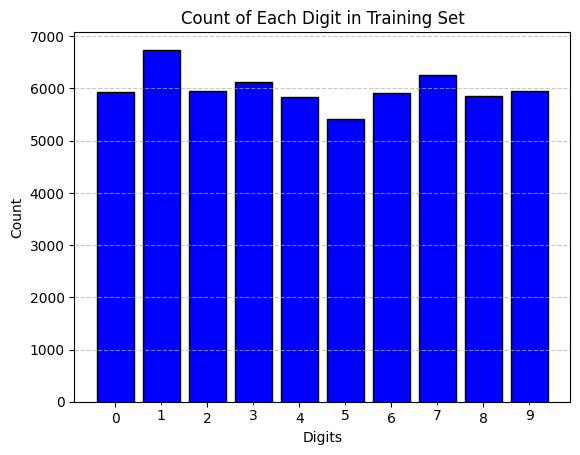

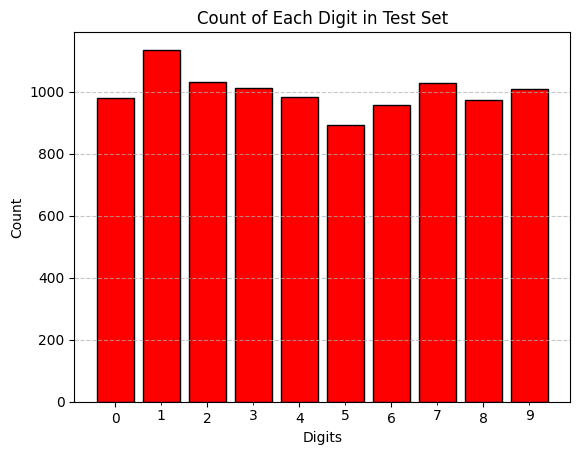

In [57]:
# Load the MNIST dataset, which is a large database of handwritten digits.
# The function returns two tuples: one for training data and one for testing data.
# Recalling, a Tuple is a collection of objects that are ordered and immutable.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# First we convert the data to float32, which helps with numerical stability. A float32 provides sufficient precision, while also being memory efficient.
# Most modern CPU's and GPU's are optimized for float32 operations, making computations faster.
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Then we convert the training data to have a channel dimension, which is required for CNNs.
X_train = X_train[..., tf.newaxis] # Add the channel dimension
X_test = X_test[..., tf.newaxis] # Add the channel dimension
print(f"New shape for X_train for CNN's: {X_train.shape}")
print(f"New shape for X_test for CNN's: {X_test.shape}")

# Declare the types of the loaded data for clarity.
X_train: NDArray[np.float32]
Y_train: NDArray[np.uint8]
X_test: NDArray[np.float32]
Y_test: NDArray[np.uint8]

# We set the line width to a large value to avoid line breaks when printing the array.
with np.printoptions(linewidth=10000):
    # Print the shapes of the datasets to understand their dimensions.
    print("Shape of X_train:\t", X_train.shape)
    print("Shape of X_test:\t", X_test.shape)
    print("Shape of Y_train:\t", Y_train.shape)
    print("Shape of Y_test:\t", Y_test.shape)
    print(f"X_train data type: {X_train.dtype}")
    print(f"X_test data type: {X_test.dtype}")
    print(f"Y_train data type: {Y_train.dtype}")
    print(f"Y_test data type: {Y_test.dtype}")

    # Inspect a single data sample to see what it looks like.
    n: int = 567
    print(f"\nX_train data {n}-th element (a 28x28 pixel image):\n", np.squeeze(X_train[n]))
    print("\nAnd its corresponding label:\t", Y_train[n])

    # TODO: For using this data in a neural network,
    # Tensorflow/Keras expects the input data to be in a 1D or 2D array format where each row represents a single sample and each column represents a feature. The general format for the input shape is: (batch_size, feature_1, feature_2, ...)
    # However, we can use the tf.keras.layers.Flatten layer as the first layer in our sequential model.
    # This layer automatically flattens the input shape without the need for manual reshaping of our data.
    # For a Dense (fully connected) network: We must flatten each 28x28 image into a single 1D array of 784 pixels. The input shape for the first layer of our model would then be (None, 784), where None represents a variable batch size.
    # For a Convolutional Neural Network (CNN): We must add a channel dimension. Since the images are grayscale, there is only one channel. We would reshape the data to (number_of_images, 28, 28, 1). The input shape for the first layer (typically a Conv2D layer) would be (28, 28, 1). The batch size is handled automatically by Keras.
    # Scaling can also be performd in the model using a tf.keras.layers.Rescaling or keras.layers.Normalization layer as the first layer in our sequential model.
    # The advantage of using these layers is that they integrate seamlessly into the model architecture, ensuring that the data is preprocessed consistently during both training and inference.
    # This approach also simplifies the code by reducing the need for separate preprocessing steps outside the model definition.
    # And, it ensures that inference data is processed in the same way as training data, which is crucial for maintaining model performance.

    # Analyze the distribution of the digits in the training set.
    # `np.unique` finds the unique digit labels and `return_counts=True` counts their occurrences.
    dataset_train_distribution: Tuple[np.ndarray, np.ndarray] = np.unique(Y_train, return_counts=True)
    digits_train: np.ndarray = dataset_train_distribution[0]
    counts_train: np.ndarray = dataset_train_distribution[1]
    
    print("\n--- Train Dataset Distribution ---")
    print("Digits:\t\t\t", digits_train)
    print("Count per digit:\t", counts_train)
    
    # Calculate basic statistics on the distribution.
    avg: float = np.mean(counts_train)
    print(f"Average sample size:\t {avg:.2f}")
    
    max_count_train: np.int64 = np.max(counts_train)
    min_count_train: np.int64 = np.min(counts_train)
    print(f"Maximum sample size:\t {max_count_train}")
    print(f"Minimum sample size:\t {min_count_train}")


    dataset_test_distribution: Tuple[np.ndarray, np.ndarray] = np.unique(Y_test, return_counts=True)
    digits_test: np.ndarray = dataset_test_distribution[0]
    counts_test: np.ndarray = dataset_test_distribution[1]
    
    print("\n--- Test Dataset Distribution ---")
    print("Digits:\t\t\t", digits_test)
    print("Count per digit:\t", counts_test)
    
    # Calculate basic statistics on the distribution.
    avg: float = np.mean(counts_test)
    print(f"Average sample size:\t {avg:.2f}")
    
    max_count_test: np.int64 = np.max(counts_test)
    min_count_test: np.int64 = np.min(counts_test)
    print(f"Maximum sample size:\t {max_count_test}")
    print(f"Minimum sample size:\t {min_count_test}")

# Create a bar chart from the counts and digits to visualize the distribution.
plt.bar(digits_train, counts_train, color='blue', edgecolor='black')

# Set the title and labels for clarity.
plt.title('Count of Each Digit in Training Set')
plt.xlabel('Digits')
plt.ylabel('Count')

# Set x-ticks to be at the center of each bar and label them with the digit.
# Minor ticks are used here to place the labels directly under the bars.
# Ticks specify the positions on the x-axis where the labels should be placed.
# By setting ticks=digits_train, we ensure that each digit (0-9) is labeled correctly under its corresponding bar.
plt.xticks(ticks=digits_train, minor=True, labels=digits_train)

# Add a grid for better readability.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot.
plt.show()

# And the same bar chart for the test set.

# Create a bar chart from the counts and digits to visualize the distribution.
plt.bar(digits_test, counts_test, color='red', edgecolor='black')

# Set the title and labels for clarity.
plt.title('Count of Each Digit in Test Set')
plt.xlabel('Digits')
plt.ylabel('Count')

# Set x-ticks to be at the center of each bar and label them with the digit.
plt.xticks(ticks=digits_test, minor=True, labels=digits_test)

# Add a grid for better readability.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot.
plt.show()

## Dataset Analysis

The content and size of the training and testing datasets align with the description on the Kaggle MNIST dataset page, Hojjat, F. (2017). MNIST: The Most Famous Dataset in the World. Kaggle. Retrieved August 28, 2025, from https://www.kaggle.com/datasets/hojjatk/mnist-dataset. The plot of digit distribution shows a fairly homogeneous representation across all classes (digits 0 through 9). While the digit '1' is slightly oversampled and the digit '5' is slightly undersampled, the class imbalance is not significant enough to warrant further action for this assessment.

In a scenario where the distribution were to be significantly imbalanced and we needed to make it more homogeneous, we would use a technique called **resampling**. Resampling involves adjusting the distribution of the training data to be more balanced. There are two primary types:

- **Oversampling** involves duplicating samples from the underrepresented classes to increase their frequency.

- **Undersampling** involves removing samples from the overrepresented classes to reduce their frequency.

## Part 1, Task 1: Creating a simple Multilayer Perceptron (MLP) neural network

The code below defines our base model.

To experiment with different architectures or tune its hyperparameters, we simply copy this entire cell and make our changes.

We need to make sure to give each new model a unique name. This ensures that when the ModelCheckpoint callback saves the best-performing version during training, the filename will be clear and identifiable.

In [58]:
# --- Set Seeds for Reproducibility ---

# This sets the global random seed for all TensorFlow operations.
# It ensures that things like model weight initialisation are the same every time.
# `tf.random.set_seed()` is the modern way to do this in TensorFlow 2.
tf.random.set_seed(1)

# This sets the random seed for all NumPy operations.
# This is important if we are creating our data using NumPy or using any
# NumPy functions that involve randomness.
np.random.seed(23)

In [59]:
# **Task 1**

# Build a neural network without convolutional layers to do the classification task (hint: you will need the use of dense layers). 
# Then you can change the model structure (i.e. number of dense layers, number of neurons in dense layers or activation functions) to be able to improve network performance.

def create_mlp_model_base() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    # Note: we can change the model architecture here. However, it is more prudent to save the model parameters first, and then change it. 
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=32, activation='relu'), # Relu is the goto activation function. We could also use LeakyRelu, tanh, sigmoid, etc.
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Base_MLP_Model")
    return model

In [60]:
def create_mlp_model_2() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=64, activation='relu'), # Relu is the goto activation function. We could also use LeakyRelu, tanh, sigmoid, etc.
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Base_MLP_Model_2")
    return model

In [61]:
# This is our first "base" model we created. Repeated here, because it yielded very good accuracies on both validate and test data, as well as loss. 
def create_mlp_model_3() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=128, activation='relu'), # Relu is the goto activation function. We could also use LeakyRelu, 
        Dense(units=256, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Base_MLP_Model_3")
    return model

In [62]:
def create_mlp_model_wide() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    # Note: we can change the model architecture here. However, it is more prudent to save the model parameters first, and then change it. 
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=1024, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Wide_MLP_Model")
    return model

In [63]:
def create_mlp_model_deep() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    # Note: we can change the model architecture here. However, it is more prudent to save the model parameters first, and then change it. 
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Deep_MLP_Model")
    return model

In [64]:
# All MLP models:
mlp_model_functions = [
create_mlp_model_base,
# create_mlp_model_2,
# create_mlp_model_3,
create_mlp_model_wide,
# create_mlp_model_deep,
]

# # Only a single model:
# mlp_model_functions = [
# create_mlp_model_3,
# ]


### Define the training loop

The 'run_experiment' function is our main pipeline for training a neural network.
It encapsulates all the necessary steps: creating the model, setting hyperparameters,
configuring callbacks for logging and monitoring, and finally training the model.
This makes our code highly modular and reusable, allowing us to easily run different
experiments by simply changing the input parameters.

In [65]:
# # The 'run_experiment' function is our main pipeline for training a neural network.
# # It encapsulates all the necessary steps: creating the model, setting hyperparameters,
# # configuring callbacks for logging and monitoring, and finally training the model.
# # This makes our code highly modular and reusable, allowing us to easily run different
# # experiments by simply changing the input parameters.

# def run_experiment(model_creation_func, hyperparameters, parent_folder, X_train, Y_train):
#     """
#     Runs a full training experiment for a given model architecture and hyperparameter set.
#     """
#     # First, we create an instance of our model by calling the function passed as an argument.
#     # This design allows us to use the same training pipeline for different model architectures.
#     model = model_creation_func()

#     # We set default values for hyperparameters. This is a good practice to ensure the
#     # function can run even if a specific hyperparameter isn't provided in the dictionary.
#     default_lr = 0.001
#     default_optimiser = 'adam'
#     default_batch_size = 64
#     default_epochs = 10
    
#     # We check if the model has a name and assign one based on the creation function if it doesn't.
#     # This helps in uniquely identifying our experiments in the log files.
#     if model.name is None or model.name == "":
#         model.name = model_creation_func.__name__

#     # --- Adapt the Normalisation Layer ---
#     print("\nAdapting the normalisation layer...")
#     # The 'adapt' method is a crucial step for preprocessing layers like Normalization.
#     # It calculates the mean and variance of the training data. This is done here,
#     # before training begins, to ensure the layer is ready to normalize our data.
#     model.layers[0].adapt(X_train)
#     print("Adaptation complete.\n")

#     print(f"\n--- Starting Experiment: {model.name} ---")

#     # We print a summary of the model's architecture. This is very useful for debugging
#     # and verifying that the layers and parameter counts are as expected.
#     print("\n--- Model Architecture ---")
#     model.summary()
#     # Generate the model's diagram as an image file
#     # plot_model(model, to_file=f'{model.name}_architecture.png', show_shapes=True, show_layer_names=True)

#     # We also print the hyperparameters used in this specific run.
#     print("\n--- Hyperparameters ---")
#     for key, value in hyperparameters.items():
#         # The '<20' is an f-string formatting option that ensures the keys are left-aligned
#         # and take up 20 characters, creating a neat, aligned output.
#         print(f"{key:<20}: {value}")

#     # --- Initialise WandB Run and Callbacks ---
#     # We start a new Weights & Biases (WandB) run here. WandB is an online platform
#     # for tracking machine learning experiments. We specify the project name, a unique
#     # run name, and the hyperparameters we want to log.
#     # The `dir` parameter is commented out to prevent local log file saving, as requested.
#     run_name = f"{model.name}-lr_{hyperparameters.get('learning_rate', default_lr)}-bs_{hyperparameters.get('batch_size', default_batch_size)}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
#     # We can uncomment the two lines below and the dir=local_log_dir to save the wandB log files locally. 
#     # local_log_dir = os.path.join(os.getcwd(), "wandb")
#     # os.makedirs(local_log_dir, exist_ok=True)

#     run = wandb.init(
#         project="CSE5ML-Assessment2",
#         name=run_name,
#         config=hyperparameters,
#         # dir=local_log_dir,
#     )

#     log_dir = os.path.join(parent_folder, "logs", model.name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#     # The Tensorboard callback is now commented out to disable local logging to Tensorboard.
#     # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
#     # We create an instance of WandbMetricsLogger. This is a Keras callback that
#     # automatically logs training metrics (like loss and accuracy) to our WandB run.
#     wandb_metrics_logger = WandbMetricsLogger()

#     # --- Configure the Optimiser ---
#     # The 'optimiser' is the algorithm that updates the network's weights during training
#     # to minimize the loss. We retrieve the name and learning rate from the hyperparameters.
#     optimiser_name = hyperparameters.get('optimiser', default_optimiser).lower()
#     learning_rate = hyperparameters.get('learning_rate', default_lr)

#     # We use an if/elif block to select the correct optimiser object.
#     # Using the object directly (e.g., `Adam()`) allows the learning rate to be
#     # explicitly set and logged, unlike when we just pass a string like 'adam'.
#     if optimiser_name == 'adam':
#         optimiser = Adam(learning_rate=learning_rate)
#     elif optimiser_name == 'sgd':
#         optimiser = SGD(learning_rate=learning_rate)
#     else:
#         optimiser = optimiser_name

#     # --- Configure the ModelCheckpoint Callback ---
#     # This callback saves the model's weights to a local file.
#     # We configure it to only save the 'best' version of the model, based on validation accuracy.
#     model_specific_folder = os.path.join(parent_folder, model.name)
#     os.makedirs(model_specific_folder, exist_ok=True)
#     filepath = os.path.join(model_specific_folder, 'best_model_epoch-{epoch:02d}_val_acc-{val_accuracy:.4f}.keras')
#     checkpoint = ModelCheckpoint(
#         filepath=filepath,
#         monitor='val_accuracy',
#         mode='max',
#         save_best_only=True,
#         verbose=1
#     )


#     # --- Add the WandBModelCheckpoint Callback ---
#     # This is a special callback that saves the model directly to the WandB cloud.
#     # It ensures that our best-performing model is always backed up online.
#     wandb_checkpoint = WandbModelCheckpoint(
#         filepath=f"wandb_models/{model.name}",
#         monitor='val_accuracy',
#         mode='max',
#         save_best_only=True,
#         verbose=1
#     )


#     # Configure the EarlyStopping callback
#     # This is a powerful technique to prevent overfitting and save training time.
#     # It monitors a metric (like validation accuracy) and stops training if that
#     # metric doesn't improve for a certain number of epochs ('patience').
#     early_stopping = EarlyStopping(
#         monitor='val_accuracy',
#         patience=10,
#         restore_best_weights=True
#     )

#     # --- Compile the Model ---
#     # This is a crucial step where we configure the model for training.
#     # We specify the optimizer, the loss function (which measures the model's error),
#     # and the metrics (which we use to evaluate its performance, like accuracy).
#     model.compile(
#         optimizer=optimiser,
#         loss=hyperparameters.get('loss_function', 'sparse_categorical_crossentropy'),
#         metrics=['accuracy']
#     )

#     # --- Train the Model ---
#     # The 'model.fit()' method is where the actual training happens.
#     # We pass in our training data, the number of epochs to run, and the batch size.
#     # The 'callbacks' list is essential, as it contains all the special functions
#     # (like our WandB and early stopping callbacks) that are executed during training.
#     history = model.fit(
#         X_train,
#         Y_train,
#         epochs=hyperparameters.get('epochs', default_epochs),
#         batch_size=hyperparameters.get('batch_size', default_batch_size),
#         validation_split=0.1,
#         callbacks=[checkpoint, wandb_metrics_logger, wandb_checkpoint, early_stopping],
#         verbose=1
#     )
#     # We attach the hyperparameters to the history object. This is a simple but effective
#     # way to keep a record of the settings used for each training run.
#     history.hyperparameters = hyperparameters

#     # After training, we find the peak performance from the validation accuracy history.
#     val_accuracies = history.history['val_accuracy']
#     best_validation_accuracy = max(val_accuracies)
#     best_epoch = val_accuracies.index(best_validation_accuracy) + 1
#     associated_train_acc = history.history['accuracy'][best_epoch - 1]

#     print("\n--- Peak Performance Summary ---")
#     print(f"{'Best validation accuracy:':<35} {best_validation_accuracy:.4f}")
#     print(f"{'Associated training accuracy:':<35} {associated_train_acc:.4f}")
#     print(f"{'Occurred at epoch:':<35} {best_epoch}")

#     return history




def run_experiment(model_creation_func, hyperparameters, parent_folder, X_train, Y_train):
    """
    Runs a full training experiment for a given model architecture and hyperparameter set.
    """
    model = model_creation_func()
    default_lr = 0.001
    default_optimiser = 'adam'
    default_batch_size = 64
    default_epochs = 10
    
    if model.name is None or model.name == "":
        model.name = model_creation_func.__name__

    print("\nAdapting the normalisation layer...")
    model.layers[0].adapt(X_train)
    print("Adaptation complete.\n")

    print(f"\n--- Starting Experiment: {model.name} ---")
    print("\n--- Model Architecture ---")
    model.summary()
    print("\n--- Hyperparameters ---")
    for key, value in hyperparameters.items():
        print(f"{key:<20}: {value}")

    run_name = f"{model.name}-lr_{hyperparameters.get('learning_rate', default_lr)}-bs_{hyperparameters.get('batch_size', default_batch_size)}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    run = wandb.init(
        project="CSE5ML-Assessment2",
        name=run_name,
        config=hyperparameters,
    )

    wandb_metrics_logger = WandbMetricsLogger()

    optimiser_name = hyperparameters.get('optimiser', default_optimiser).lower()
    learning_rate = hyperparameters.get('learning_rate', default_lr)

    if optimiser_name == 'adam':
        optimiser = Adam(learning_rate=learning_rate)
    elif optimiser_name == 'sgd':
        optimiser = SGD(learning_rate=learning_rate)
    else:
        optimiser = optimiser_name

    # This local checkpoint saves the model to our hard drive. This is correct.
    model_specific_folder = os.path.join(parent_folder, run_name)
    os.makedirs(model_specific_folder, exist_ok=True)
    filepath = os.path.join(model_specific_folder, 'best_model_epoch-{epoch:02d}_val_acc-{val_accuracy:.4f}.keras')
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # The filepath for the WandB artifact correctly includes a filename ending in .keras
    wandb_checkpoint = WandbModelCheckpoint(
        filepath=f"wandb_models/{run_name}/best_model.keras", # Corrected this line
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    model.compile(
        optimizer=optimiser,
        loss=hyperparameters.get('loss_function', 'sparse_categorical_crossentropy'),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train,
        Y_train,
        epochs=hyperparameters.get('epochs', default_epochs),
        batch_size=hyperparameters.get('batch_size', default_batch_size),
        validation_split=0.1,
        callbacks=[checkpoint, wandb_metrics_logger, wandb_checkpoint, early_stopping],
        verbose=1
    )
    history.hyperparameters = hyperparameters

    val_accuracies = history.history['val_accuracy']
    best_validation_accuracy = max(val_accuracies)
    best_epoch = val_accuracies.index(best_validation_accuracy) + 1
    associated_train_acc = history.history['accuracy'][best_epoch - 1]

    print("\n--- Peak Performance Summary ---")
    print(f"{'Best validation accuracy:':<35} {best_validation_accuracy:.4f}")
    print(f"{'Associated training accuracy:':<35} {associated_train_acc:.4f}")
    print(f"{'Occurred at epoch:':<35} {best_epoch}")

    run.finish()

    return history

In [66]:
# In the cell above, we store all the models, run history, and hyperparameters in the Wandb cloud platform. We save the model architectures + their best W ad b Locally as well.
# The function below can be used to pull all that data from the cloud and store it locally as well. 
# This can be useful if we want to analyse it with python. E.g., plotting the accuracy and losses locally, rather than in the cloud with limited customisation tools. 

def pull_wandb_data_from_cloud(project_name, local_dir):
    """
    Pulls all runs, models, and artifacts from a WandB project
    and stores them locally, using the run's expressive name for the folder.

    Args:
        project_name (str): The name of the WandB project.
        local_dir (str): The local directory to save the data.
    """
    print(f"Connecting to WandB project: {project_name}")
    api = wandb.Api()
    
    try:
        user_name = api.default_entity
    except wandb.errors.CommError:
        print("Error: Could not retrieve WandB username. Make sure you are logged in.")
        return
        
    os.makedirs(local_dir, exist_ok=True)
    
    runs = api.runs(f"{user_name}/{project_name}")
    
    print(f"Found {len(runs)} runs for user: {user_name}. Downloading data...")

    for run in runs:
        # --- Fix: Create a clean, expressive folder name ---
        # 1. Start with the expressive run name.
        run_folder_name = run.name
        
        # 2. Sanitize the name to remove any characters that are invalid for file paths.
        sanitized_run_name = re.sub(r'[\\/:*?"<>|]', '_', run_folder_name)
        
        # 3. We no longer append the unique run ID, since the timestamp already ensures uniqueness.
        final_folder_name = sanitized_run_name
        
        # Construct the full path for the run's local directory.
        run_dir = os.path.join(local_dir, final_folder_name)
        os.makedirs(run_dir, exist_ok=True)
        
        # Download all files associated with the run
        for file in run.files():
            file.download(root=run_dir, exist_ok=True)
            
        print(f"Downloaded files for run: {final_folder_name}")

        # Download artifacts (including models)
        for artifact in run.logged_artifacts():
            print(f"Downloading artifact: {artifact.name}")
            
            sanitized_artifact_name = re.sub(r'[\\/:*?"<>|]', '_', artifact.name)
            
            artifact_dir = os.path.join(run_dir, "artifacts", sanitized_artifact_name)
            os.makedirs(artifact_dir, exist_ok=True)
            artifact.download(root=artifact_dir)

    print("Download complete.")

In [67]:
# # We get the current working directory.
# current_dir = os.getcwd()
# # We create the parent folder path using os.path.join.
# parent_folder_name = "WandB_downloads"
# wandb_folder = os.path.join(current_dir, parent_folder_name)
# # We now call the function with the correct local directory.
# pull_wandb_data_from_cloud("CSE5ML-Assessment2", wandb_folder)

### Define sets of hyperparameters

The cell below allow us to set a plethora of hyperparameters, such as the learning rate, batch_size, but also the optimiser and the number of epochs the training loop is run for. 

In [68]:
# --- Define Hyperparameter Sets ---
# Part 1 Task 3 only requires one experiment with an MLP, so we will just define one hyperparameter set for the MLP here.
mlp_epochs = 100
mlp_batch_size = 64
# Experiment 1: Our baseline run
# We choose SGD as our optimiser because it is expected that the loss landscape of our simple MLP model is largely convex. 
mlp_exp_1_config = {
    "optimiser": "SGD",
    "learning_rate": 0.01, # The optimal, or at least a satisfactory LR will have to be identified by experimenting. We start with LR = 0.01. This does not lead to convergence of Loss and Accuracy. So LR=0.001 is used. 
    "epochs": mlp_epochs,
    "batch_size": mlp_batch_size
}


# # Experiment 2: Same as the MLP_Baseline but with a lower learning rate
# mlp_exp_2_config = {
#     "optimiser": "Adam",
#     "learning_rate": 0.001,
#     "epochs": mlp_epochs,
#     "batch_size": mlp_batch_size,
# }

# # Experiment 3: Same as the MLP_Baseline but with a different optimizer (SGD)
# mlp_exp_3_config = {
#     "optimiser": "SGD",
#     "learning_rate": 0.01,
#     "epochs": mlp_epochs,
#     "batch_size": mlp_batch_size,
# }

# # Experiment 4: Same as the MLP_Baseline but with a different optimizer (SGD) and a lower learning rate
# mlp_exp_4_config = {
#     "optimiser": "SGD",
#     "learning_rate": 0.001,
#     "epochs": mlp_epochs,
#     "batch_size": mlp_batch_size,
# }

In [69]:
# --- Run the full list of models ---
run_mlp_experiments = True

if run_mlp_experiments:
    mlp_histories = []
    for mlp_model_function in mlp_model_functions:
        mlp_history = run_experiment(
            model_creation_func=mlp_model_function, 
            # But use only one set of hyperparameters for now.
            hyperparameters=mlp_exp_1_config, 
            parent_folder='MLP_Models',
            X_train=X_train,
            Y_train=Y_train,
        )
        mlp_histories.append(mlp_history)

# # --- To run the second experiment, we just call it again with a different config (hyper parameter set) :-)
# --- We first  test different model architectures before running more experiments with different hyperparameters (Part 1 Task 1 & 2). ---
# --- THen we test the best performing model of Part 1 Task 1& 2 with different hyperparameters. ---


Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model ---

--- Model Architecture ---


Model: "Base_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_8 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,645 (115.80 KB)

 Trainable params: 29,642 (115.79 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
799/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6275 - loss: 1.1587
Epoch 1: val_accuracy improved from None to 0.91467, saving model to MLP_Models\Base_MLP_Model-lr_0.01-bs_64-20250916-153139\best_model_epoch-01_val_acc-0.9147.keras

Epoch 1: val_accuracy improved from None to 0.91467, saving model to wandb_models/Base_MLP_Model-lr_0.01-bs_64-20250916-153139/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7908 - loss: 0.6822 - val_accuracy: 0.9147 - val_loss: 0.2944
Epoch 2/100
825/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9012 - loss: 0.3282
Epoch 2: val_accuracy improved from 0.91467 to 0.93283, saving model to MLP_Models\Base_MLP_Model-lr_0.01-bs_64-20250916-153139\best_model_epoch-02_val_acc-0.9328.keras

Epoch 2: val_accuracy improved from 0.91467 to 0.93283, saving model to wandb_models/Base_MLP_Model-lr_0.01-bs_64-20250916-153139/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9079 - loss: 0.3103 - val_

KeyboardInterrupt: 

# Notes on Sparse Categorical Loss vs. Categorical Loss
# Understanding Cross-Entropy Loss

At its heart, **cross-entropy** is a concept from information theory that measures how different two probability distributions are. In the context of training a neural network for classification, we use it to measure the "distance" between the model's predicted probability distribution and the true probability distribution of the labels. The goal of training is to minimise this distance, effectively making the model's predictions more accurate (Goodfellow et al., 2016).

---
### Categorical Cross-Entropy (for One-Hot Labels)

You use this loss function when your labels are explicitly **one-hot encoded** (e.g., the digit `3` is represented as `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`). The formula for a single sample is:

$$L = -\sum_{i=0}^{C-1} y_i \log(\hat{y}_i)$$

-   $L$ is the final loss value for the sample.
-   $C$ is the total number of classes (e.g., 10 for MNIST).
-   $y_i$ is the ground truth (it is `1` for the correct class and `0` for all others).
-   $\hat{y}_i$ is the model's predicted probability for class $i$.

Because the `y` vector is almost all zeros, the summation simplifies to just the negative logarithm of the probability the model assigned to the single correct class. For a label of `3`, the loss simply becomes $L = -\log(\hat{y}_3)$.

---
### Sparse Categorical Cross-Entropy (for Integer Labels)

This is a more computationally and memory-efficient version used when your labels are simple **integers** (e.g., `3`). It arrives at the exact same mathematical result but skips the need for the one-hot encoded vector.

The formula is a direct implementation of the simplified logic:

$$L = -\log(\hat{y}_c)$$

-   $L$ is the final loss value for the sample.
-   $c$ is the integer representing the correct class (e.g., `c = 3`).
-   $\hat{y}_c$ is the model's predicted probability for that correct class $c$.

As Chollet (2021) explains, both formulas compute the exact same value. The choice is purely a practical one based on the format of your labels, not a mathematical one that affects the model's learning.

---
**References**

Chollet, F. (2021). *Deep learning with Python* (2nd ed.). Shelter Island, NY: Manning Publications.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep learning*. Cambridge, MA: MIT Press.

## Part 1, Task 2: Creating a simple Convolutional Neural Network (CNN)

The code below defines our base model.

To experiment with different architectures or tune its hyperparameters, we simply copy this entire cell and make our changes.

We need to make sure to give each new model a unique name. This ensures that when the ModelCheckpoint callback saves the best-performing version during training, the filename will be clear and identifiable.

In [ ]:
# **Task 2**

# Build a neural network with the use of convolutional layers (you can decide other layer types you want to include in your network). 
# Then you can change the number of convolutional layers and the number of filters or activation functions in the convolutional layers to be able to improve network performance.

def create_cnn_model_base() -> Sequential:
    """
    Defines the base CNN model architecture with Dropout for regularization.
    """
    model = Sequential([
        # Preprocessing layers
        Input(shape=(28, 28, 1)),
        Normalization(),
        
        # --- Convolutional Block 1 ---
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Convolutional Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # --- Classification Head ---
        Flatten(),
        # Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Base_CNN")
    return model    

In [ ]:
# Create a second CNN base model with the same architecture, but a dropout in the classification head.
def create_cnn_model_base_dropout() -> Sequential:
    """
    Defines and returns the base CNN model architecture with dropout in the classification head.
    """
    model = Sequential([
        # Preprocessing layers
        Input(shape=(28, 28, 1)),
        Normalization(),
            
        # --- Convolutional Block 1 ---
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Convolutional Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # --- Classification Head ---
        Flatten(),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="CNN_with_Dropout")
    return model

In [ ]:
# Create a wide CNN 
def create_cnn_model_wide() -> Sequential:
    """
    Defines and returns a wide CNN model architecture.
    """
    model = Sequential([
        # Preprocessing layers
        Input(shape=(28, 28, 1)),
        Normalization(),
        
        # --- Convolutional Block 1 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Convolutional Block 2 ---
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # --- Classification Head ---
        Flatten(),
        Dropout(0.5),
        Dense(units=256, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Wide_CNN_Model")
    return model

In [ ]:
def create_cnn_model_deep() -> Sequential:
    """
    Defines and returns a deep CNN model architecture with padding to preserve dimensions.
    """
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Normalization(),
        
        # --- Convolutional Block 1 ---
        # Add padding='same' to all Conv2D layers, so we preserve the spatial dimensions. If we don't do this, the image shrinks too quickly.
        # and no meaningful features can be extracted.
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)), # This is where the shrinking now happens (28x28 -> 14x14)

        # --- Convolutional Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)), # Second shrink (14x14 -> 7x7)
        
        # --- Classification Head ---
        # The input to Flatten is now a healthy 7x7x64=3,136 full of rich features.
        Flatten(),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Deep_CNN_Model_Padded")
    return model

In [ ]:
cnn_model_functions = [
# create_cnn_model_base,
create_cnn_model_base_dropout,
create_cnn_model_wide,
# create_cnn_model_deep, # We teain the deep network separately with a much lower LR. We have observed that this model performs no better than a random guess (i.e. 10% val. accuracy)
# Almost certainly this has to do with the LR, the model can't get to the valleys of the loss landscape, as it overshoots. 
# Future to do: Find a way to reduce the loss landscape to 3D, or 2D dimension, and show the parth the Optimiser takes, to be able to demonstrate the effect of the LR. 
]


# cnn_model_functions = [
# create_cnn_model_deep,
# ]

# Plotting all model architectures

In [ ]:
# The 'text_callable' function is a special callback used by the visualkeras library. 
# Its main job is to create the text label that appears on top of or next to each
# layer block in the generated visualization. It's called once for every layer in your model.

def text_callable(layer_index, layer):
    # 'layer_index' is an integer representing the position of the layer in the model's sequence.
    # 'layer' is the actual Keras layer object itself (e.g., a Conv2D, Dense, or Flatten layer).

    # The boolean value 'above' is used to alternate the vertical position of the text labels.
    # By using the modulo operator (%), we check if the layer's index is odd or even.
    # This ensures that the text labels don't overlap, making the visualization cleaner.
    above = bool(layer_index % 2)

    # We use a 'try...except' block as a defensive programming practice.
    # This helps the code run without crashing even if it encounters unexpected errors.
    try:
        # We first try to get the layer's output shape using the 'layer.output.shape' attribute.
        # This is the standard way to get shape information in modern TensorFlow.
        shape = layer.output.shape
    except AttributeError:
        # If the first attempt fails (e.g., if the layer is not yet built), we move to this block.
        # This is a fallback to ensure compatibility with different Keras versions and layer types.
        try:
            # Here, we try to access the 'layer.output_shape' attribute, which was more common
            # in older versions of Keras. This helps the function work with a wider range of models.
            shape = layer.output_shape
        except AttributeError:
            # If both attempts to get the shape fail, it means the layer doesn't have a defined output shape.
            # This can happen for a number of reasons. In this case, we return a label
            # that says "Shape N/A" to indicate the issue without crashing the program.
            return f"{layer.name}\n(Shape N/A)", above

    # Keras represents shapes in various ways. For instance, a single-output layer might
    # return a shape as a list, a tuple, or a special 'TensorShape' object.
    # This 'if' statement handles the case where the shape is returned as a nested list,
    # ensuring we only work with the first (and typically most relevant) shape.
    if isinstance(shape, list):
        shape = shape[0]

    # 'TensorShape' is a specific object type in TensorFlow. To manipulate its values,
    # we need to convert it into a standard Python list. The 'as_list()' method does this for us.
    if isinstance(shape, tf.TensorShape):
        output_shape = shape.as_list()
    else:
        # If the shape is already a list or tuple, we simply convert it to a list.
        output_shape = list(shape)
    
    # Keras models often have a 'None' dimension in their shape to represent the
    # variable batch size. For our visualization, we don't need this, as it would just
    # clutter the output. This line uses a list comprehension to filter out the 'None' value.
    output_shape = [dim for dim in output_shape if dim is not None]
    
    # We add an offset to the text position here.
    # The offset will push the text away from the layers.
    # This simulates padding around the text.
    # 
    # Please note that the actual padding is controlled by the 'padding' and 'spacing'
    # parameters in the 'visualkeras.layered_view()' function, but a clever use of
    # this function can also help with text positioning.

    # We initialize an empty string to build our final text label.
    output_shape_txt = ""

    # 'enumerate' is a handy built-in Python function. It allows us to loop through a sequence
    # (in this case, our list of shape dimensions) and get both the index ('ii') and the
    # value ('dim') at the same time. This is perfect for when we need to perform an action
    # based on an item's position, like adding 'x' or a newline.
    for ii, dim in enumerate(output_shape):
        # We append the current dimension (as a string) to our text label.
        output_shape_txt += str(dim)
        
        # This line is for debugging purposes. It prints the shape to the console
        # to help us verify what the function is seeing. We can remove this later.
        # print(f'Output shape: {output_shape}')

        # We want to add an 'x' between the dimensions (e.g., 28x28). This 'if' statement
        # checks if we are not at the last two dimensions of the shape, as the format is different there.
        if ii < len(output_shape) - 2:
            output_shape_txt += "x"

        # This 'if' statement adds a newline character to create the desired format
        # where the last dimension is on a new line (e.g., 28x28\n64).
        if ii == len(output_shape) - 2:
            output_shape_txt += "\n" #\n here is the space between the output shape and nr of filteres (e.g. 28 x 28, 32) and the keras name for the layer. 




    # --- General Check for Attributes ---
    # We check if the layer has an 'activation' attribute.
    if hasattr(layer, 'activation') and layer.activation is not None:
        activation = layer.activation.__name__
        output_shape_txt += f"\n{activation}"
    
    # We check if the layer has a 'kernel_size' attribute.
    if hasattr(layer, 'kernel_size') and layer.kernel_size is not None:
        kernel_size = layer.kernel_size
        output_shape_txt += f"\nKernel: {kernel_size}"

    # Finally, we add the name of the layer to our text, preceded by a newline, to ensure
    # the layer name appears on a new line below the shape.
    # output_shape_txt += f"\n{layer.name}" #\n is the space between the feature size (e.g. 28 x 28) and the number of filters (if any)
    output_shape_txt += f"\n\n" #\n is the space between the feature size (e.g. 28 x 28) and the number of filters (if any)
    # The function returns the complete text string and the boolean value 'above',
    # which tells visualkeras where to place the label relative to the layer block.

    return output_shape_txt, above

In [ ]:
def visualise_model(model: Model, style: str = 'layered'):
    """
    Generates and displays a visual architecture plot for a given Keras model,
    with advanced customization options.
    """
    print(f"--- Visualizing Architecture for: {model.name} (Style: {style}) ---")
    
    # Define a custom color map for the layers.
    # We use defaultdict for a default grey color if a layer type isn't specified.
    color_map = defaultdict(lambda: {'fill': '#999999'})
    color_map[Conv2D] = {'fill': '#00B8D4'}
    color_map[MaxPooling2D] = {'fill': '#FFAB00'}
    color_map[Dense] = {'fill': '#651FFF'}
    color_map[Flatten] = {'fill': '#E91E63'}
    color_map[Normalization] = {'fill': '#BDBDBD'}

    # Define a custom font for the text labels.
    # The font size can be adjusted here.
    custom_font = ImageFont.truetype("arial.ttf", 14)

    # We use a 'with' statement to temporarily ignore any minor warnings
    # from the visualkeras library, which keeps our output clean.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        
        if style == 'layered':
            # This is the core function call for creating the visualization.
            # We use the advanced parameters from the provided example code.
            # The function now takes the model as an argument, as requested.
            advanced_layered_img = visualkeras.layered_view(
                model,
                text_callable=text_callable,
                legend=True,  # Shows a legend to explain what each color represents.
                font=custom_font, # Applies our custom-defined font.
                color_map=color_map, # Uses our custom color scheme.
                draw_volume=True,  # Renders the layers as 3D blocks.
                draw_funnel=True,  # Shows a funnel shape to represent data compression.
                spacing=30,  # Increases the horizontal space between layers for better readability.
                padding=50,  # Adds a border around the entire image to prevent text cutoff.
                scale_xy=3, # Adjusts the scale of the layers' width and depth.
                scale_z=2,  # Adjusts the scale of the layers' height.
                min_xy=10,
                max_z=500, # Caps the maximum height of a layer block.
                max_xy = 500,
                font_color='black', # Sets the text color for the legend and labels.
                one_dim_orientation='y', # Sets the orientation for 1D layers like Flatten.
                # sizing_mode='accurate', # Ensures that the layer sizes are proportionally accurate.
                type_ignore=[Flatten, Dropout], # Excludes Flatten and Dropout layers from the main diagram.
            )
            
            # Display the generated image.
            display(advanced_layered_img)

        elif style == 'graph':
            # This is an alternative view that creates a simpler 2D diagram.
            display(visualkeras.graph_view(
                model,
                color_map=color_map
            ))
        else:
            # Error handling for an unknown style.
            print(f"Error: Unknown style '{style}'. Please choose 'layered' or 'graph'.")

## Plotting the MLP models

--- Visualizing Architecture for: Base_MLP_Model (Style: layered) ---


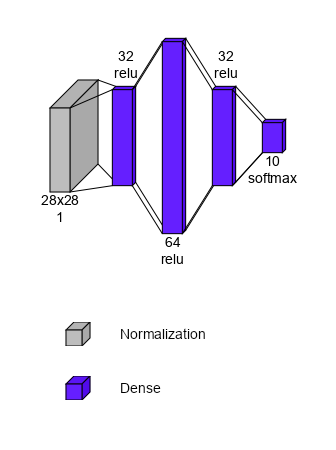

Model: "Base_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,645 (115.80 KB)

 Trainable params: 29,642 (115.79 KB)

 Non-trainable params: 3 (16.00 B)


--- Visualizing Architecture for: Wide_MLP_Model (Style: layered) ---


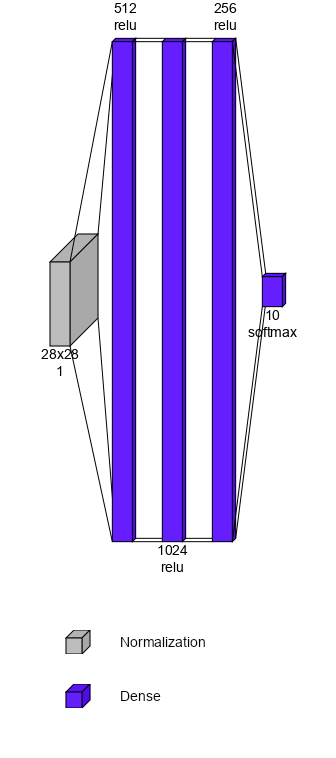

Model: "Wide_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,205 (4.55 MB)

 Trainable params: 1,192,202 (4.55 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
# # Now, loop through, create each model "on the fly", and plot it

for model_creation_function in mlp_model_functions:
    # 1. Create the model instance from the function
    model_instance = model_creation_function()

    # Manually build the model with the correct input shape.
    # The `None` indicates a variable batch size. In the case of the MLP, this is an irrelevant parameter. None prevents this code from crashing for MLP models. 
    model_instance.build(input_shape=(None, 28, 28, 1)) 

    # 2. Call the plotting function to visualize it
    visualise_model(model_instance, style='layered')
    
    # 3. Print the model summary.
    model_instance.summary()

    # Where are the activation functions stored?

    
    print("="*60 + "\n") # Add a separator for clarity

## Plotting the CNN models

--- Visualizing Architecture for: CNN_with_Dropout (Style: layered) ---


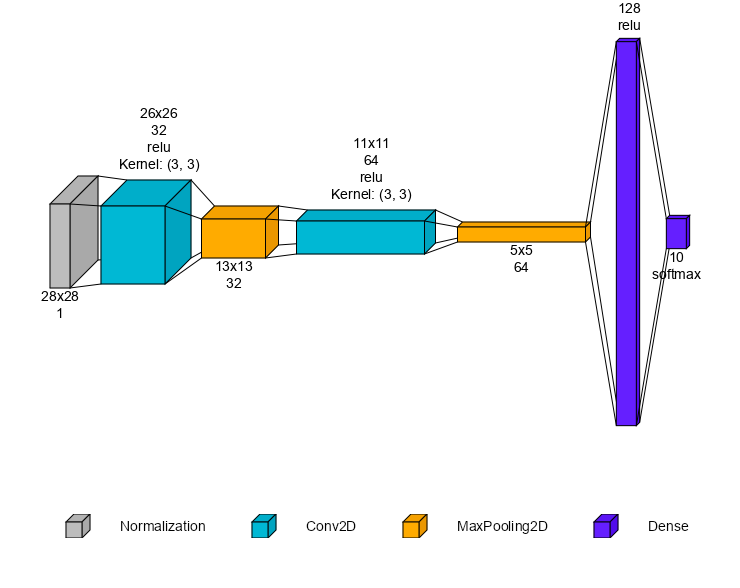

Model: "CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Visualizing Architecture for: Wide_CNN_Model (Style: layered) ---


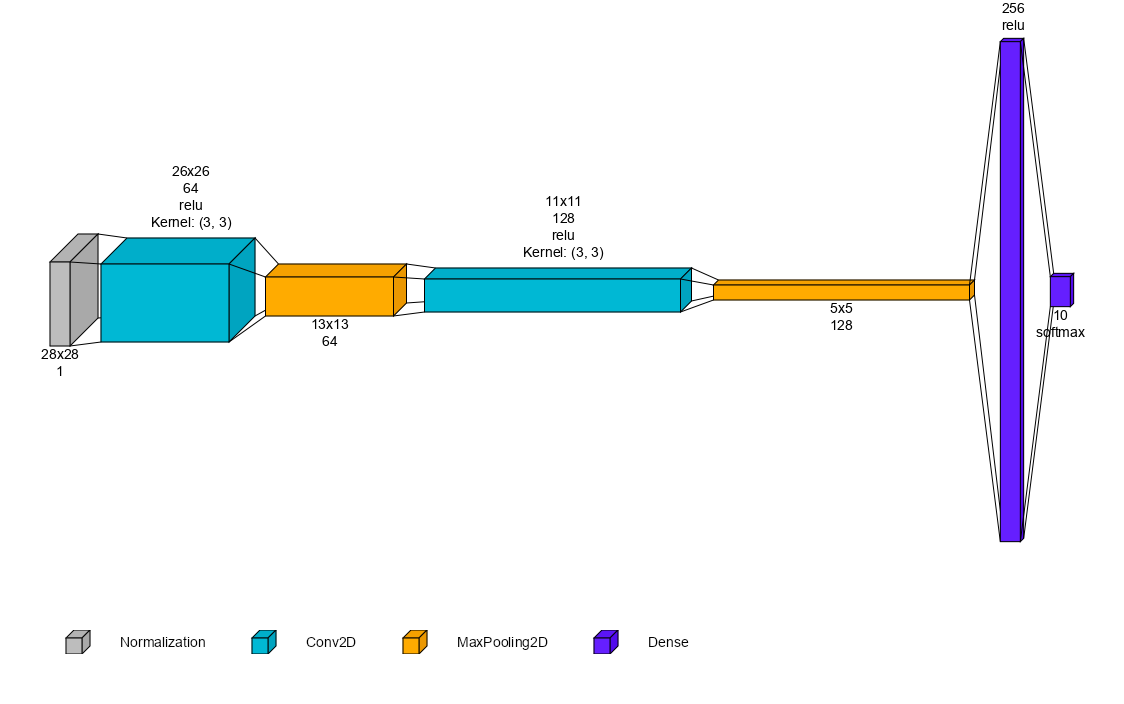

Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,525 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
# # Now, loop through, create each model "on the fly", and plot it

for model_creation_function in cnn_model_functions:
    # 1. Create the model instance from the function
    model_instance = model_creation_function()

    # Manually build the model with the correct input shape.
    # The `None` indicates a variable batch size. In the case of the MLP, this is an irrelevant parameter. None prevents this code from crashing for MLP models. 
    model_instance.build(input_shape=(None, 28, 28, 1)) 

    # 2. Call the plotting function to visualize it
    visualise_model(model_instance, style='layered')
    

    # 3. Print the model summary.
    model_instance.summary()

    print("="*60 + "\n") # Add a separator for clarity



## Defining hyperparameters for the CNN models

In [ ]:
# --- Define Hyperparameter Set for the CNN models ---
cnn_epochs = 100
cnn_batch_size = 64
cnn_exp_1_config = {
    "optimiser": "Adam",
    "learning_rate": 0.01,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}
cnn_exp_2_config = {
    "optimiser": "Adam",
    "learning_rate": 0.001,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}

cnn_exp_3_config = {
    "optimiser": "SGD",
    "learning_rate": 0.01,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}

cnn_exp_4_config = {
    "optimiser": "SGD",
    "learning_rate": 0.001,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}

cnn_config = [cnn_exp_2_config] # ,cnn_exp_3_config, cnn_exp_4_config
# cnn_exp_1_config,  We do not need to include the cnn_exp_1_config, because we have already run this on all models. 
# In the cell below, setting the all_exp_params is a flag that ensure that when set to True, all models are trained on all parameters (computationally intensive)

In [ ]:
run_cnn_experiments = True # A simple flag to control whether we run the CNN experiments or not. This is convenient because CNN experiments take longer to run.
# and when we restart the notebook, we might want to just run the MLP experiments first.
all_exp_params = True

# --- Run the full list of experiments ---
if run_cnn_experiments:
    cnn_histories = []
    for cnn_model_function in cnn_model_functions:
        if not all_exp_params:
            cnn_history = run_experiment(
                model_creation_func=cnn_model_function, 
                hyperparameters=cnn_exp_1_config,  # If we do not set the all experiment parameters to True, then we only need the 1 config file. 
                parent_folder='CNN_Models',
                X_train=X_train,
                Y_train=Y_train,
            )
        else:
            for config in cnn_config:
                cnn_history = run_experiment(
                    model_creation_func=cnn_model_function, 
                    hyperparameters=config, 
                    parent_folder='CNN_Models',
                    X_train=X_train,
                    Y_train=Y_train,
                )

        cnn_histories.append(cnn_history)

# # --- To run the second experiment, we just call it again with a different config (hyper parameter set) :-)
# --- We first  test different model architectures before running more experiments with different hyperparameters (Part 1 Task 1 & 2). ---
# --- THen we test the best performing model of Part 1 Task 1& 2 with different hyperparameters. ---


Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: CNN_with_Dropout ---

--- Model Architecture ---


Model: "CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : Adam
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8784 - loss: 0.3779
Epoch 1: val_accuracy improved from None to 0.98550, saving model to CNN_Models\CNN_with_Dropout-lr_0.001-bs_64-20250916-142517\best_model_epoch-01_val_acc-0.9855.keras

Epoch 1: val_accuracy improved from None to 0.98550, saving model to wandb_models/CNN_with_Dropout-lr_0.001-bs_64-20250916-142517/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9448 - loss: 0.1778 - val_accuracy: 0.9855 - val_loss: 0.0494
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9772 - loss: 0.0719
Epoch 2: val_accuracy improved from 0.98550 to 0.98967, saving model to CNN_Models\CNN_with_Dropout-lr_0.001-bs_64-20250916-142517\best_model_epoch-02_val_acc-0.9897.keras

Epoch 2: val_accuracy improved from 0.98550 to 0.98967, saving model to wandb_models/CNN_with_Dropout-lr_0.001-bs_64-20250916-142517/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9785 - l

epoch/accuracy,▁▆▆▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▇█▇█▇▇▇██▇▇▇█▇▇█▇▇
epoch/val_loss,█▅▄▃▂▂▂▂▃▂▂▁▂▂▃▃▁▃▃▃▄▃
epoch/accuracy,0.99604
epoch/epoch,21
epoch/learning_rate,0.001
epoch/loss,0.01159
epoch/val_accuracy,0.99367



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_CNN_Model ---

--- Model Architecture ---


Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_7 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,525 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : Adam
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9034 - loss: 0.2973
Epoch 1: val_accuracy improved from None to 0.98750, saving model to CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250916-143001\best_model_epoch-01_val_acc-0.9875.keras

Epoch 1: val_accuracy improved from None to 0.98750, saving model to wandb_models/Wide_CNN_Model-lr_0.001-bs_64-20250916-143001/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.9558 - loss: 0.1409 - val_accuracy: 0.9875 - val_loss: 0.0408
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9828 - loss: 0.0556
Epoch 2: val_accuracy improved from 0.98750 to 0.99150, saving model to CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250916-143001\best_model_epoch-02_val_acc-0.9915.keras

Epoch 2: val_accuracy improved from 0.98750 to 0.99150, saving model to wandb_models/Wide_CNN_Model-lr_0.001-bs_64-20250916-143001/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.9834 - loss: 0.0

epoch/accuracy,▁▆▆▇▇▇▇▇▇▇████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▆▆▅▆▇▇▇▇██▇▅█▇▆▇▇▆█▇▇▇▇
epoch/val_loss,▇▃▃▃▃▅▃▂▁▂▃▃▂▆█▄▅▇▆▄█▅▇▆█▅
epoch/accuracy,0.99802
epoch/epoch,25
epoch/learning_rate,0.001
epoch/loss,0.0062
epoch/val_accuracy,0.99383


In [77]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import History
from types import SimpleNamespace
import pandas as pd

def plot_training_history(history_data, run_name_override=None):
    """
    Plots training & validation accuracy and loss from either a Keras History object
    or a SimpleNamespace object containing WandB run data.

    Args:
        history_data: A Keras History object or a SimpleNamespace object.
        run_name_override (str, optional): A name to use for the plot title.
                                           If None, it will try to infer the name.
    """
    history_dict = None
    config = {}
    run_name = "Unknown Run"

    # --- 1. ROBUST FIX: Use duck typing to identify the object ---
    # Instead of a strict type check, we check if it has the attributes we need.
    if hasattr(history_data, 'history') and isinstance(history_data.history, dict):
        # This is a Keras History object from model.fit()
        history_dict = history_data.history
        if hasattr(history_data, 'hyperparameters'):
            config = history_data.hyperparameters
        if hasattr(history_data, 'model'):
            run_name = history_data.model.name
            
    elif isinstance(history_data, SimpleNamespace):
        # This is our custom object from load_local_run_data()
        if hasattr(history_data, 'history') and isinstance(history_data.history, pd.DataFrame):
            # The history DataFrame needs its columns converted to lists for plotting
            history_dict = {col: history_data.history[col].tolist() for col in history_data.history.columns}
        if hasattr(history_data, 'config'):
            config = history_data.config
        if hasattr(history_data, 'name'):
            run_name = history_data.name
    
    # Use the override name if provided
    if run_name_override:
        run_name = run_name_override

    # Check if we successfully extracted the data
    if not history_dict:
        print("Error: Unsupported or invalid data type provided. Could not extract history.")
        return

    # --- 2. Extract and Format Hyperparameters for the Title ---
    optimizer_name = config.get('optimiser', 'N/A')
    learning_rate = config.get('learning_rate', 'N/A')
    batch_size = config.get('batch_size', 'N/A')
    subtitle = f"Optimizer: {optimizer_name}, LR: {learning_rate}, Batch Size: {batch_size}"

    # --- 3. Generate the Plots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Training History for: {run_name}\n{subtitle}', fontsize=16)

    # Plot training & validation accuracy values
    if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
        ax1.plot(history_dict['accuracy'], label='Train Accuracy')
        ax1.plot(history_dict['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc='lower right')
        ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot training & validation loss values
    if 'loss' in history_dict and 'val_loss' in history_dict:
        ax2.plot(history_dict['loss'], label='Train Loss')
        ax2.plot(history_dict['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(loc='upper right')
        ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Plot the results of every epoch

1. Using History objects

The number of models to plot: 0
The number of models to plot: 2
Model number: 1


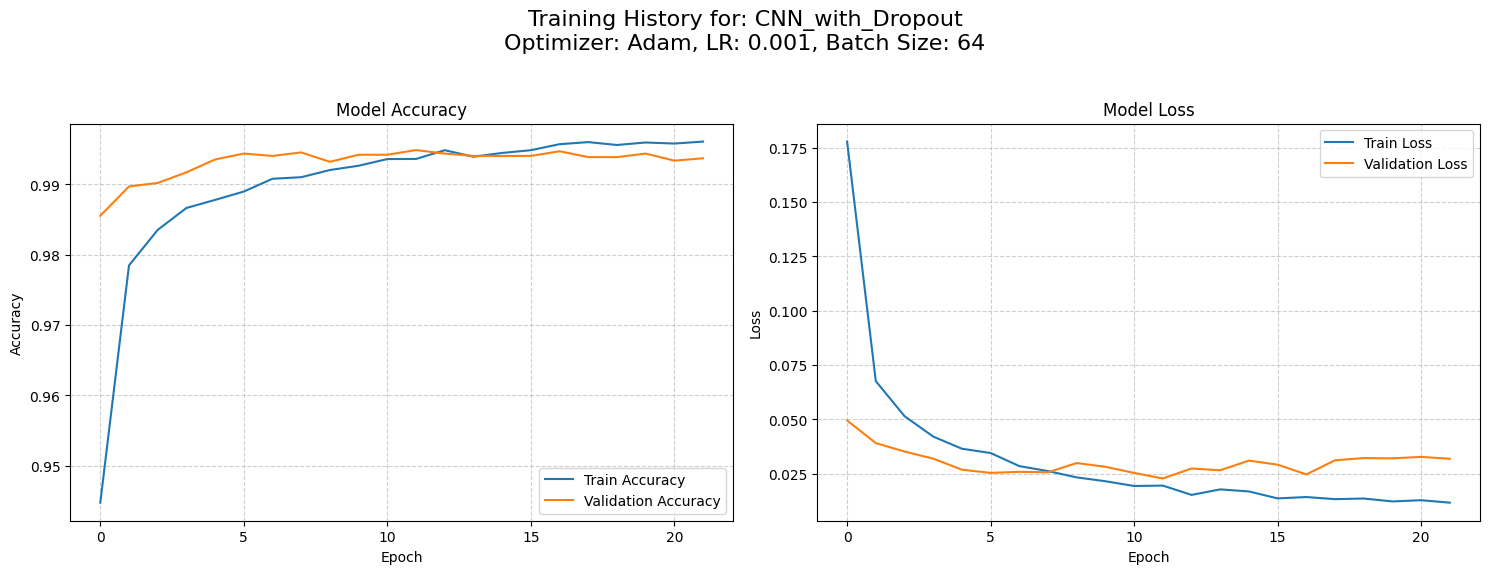

----------------------------------------------------------------------------------------------------
Model number: 2


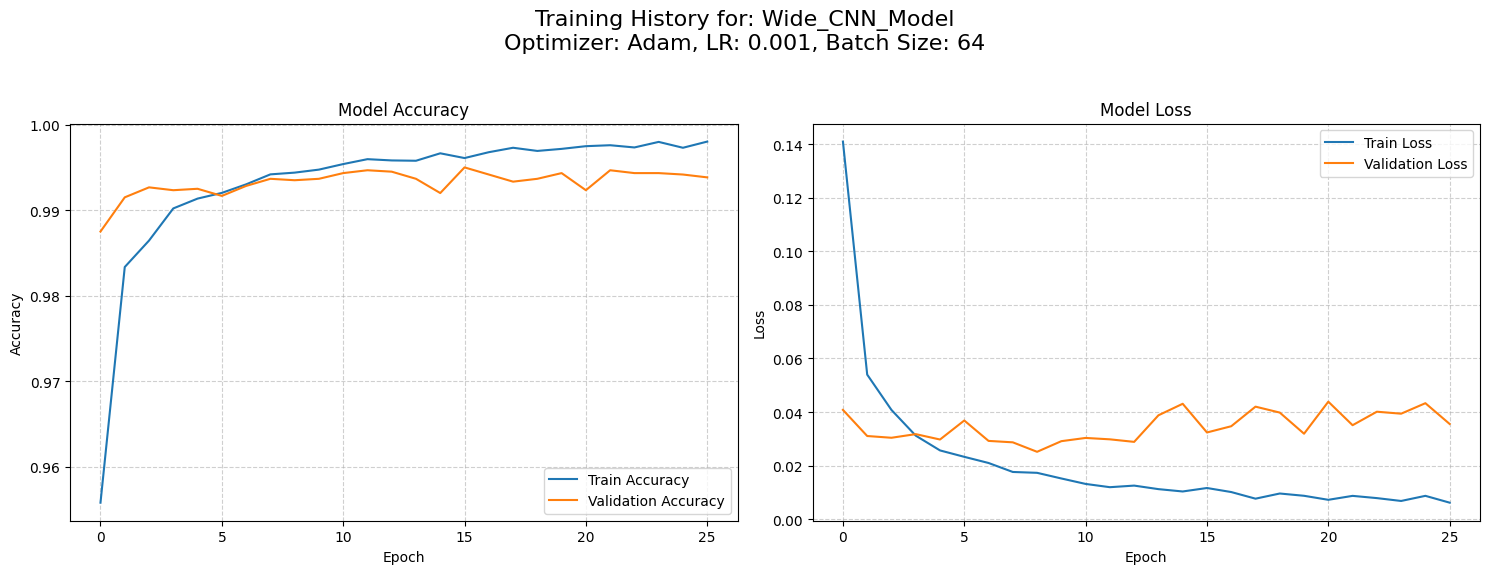

----------------------------------------------------------------------------------------------------


In [78]:
# A simple wrapper function to print all histories in a list.
def print_training_histories(histories):
    print(f"The number of models to plot: {len(histories)}")
    for history in histories:
        print(f"Model number: {histories.index(history)+1}")
        plot_training_history(history)
        print("-"*100)

if run_mlp_experiments:
    print_training_histories(mlp_histories)
if run_cnn_experiments:
    print_training_histories(cnn_histories)


2. Using WandB run objects

In [75]:
def load_and_plot_all_runs(parent_folder: str):
    """
    Scans all subdirectories in a parent folder, loads the WandB run data 
    (config and history) from each, and then calls the universal plotting function 
    for each valid run found. This function is self-contained.

    Args:
        parent_folder (str): The path to the directory containing all downloaded run folders.
    """
    print(f"--- Scanning and plotting all runs in '{parent_folder}' ---")
    if not os.path.isdir(parent_folder):
        print(f"Error: Directory not found at '{parent_folder}'")
        return

    run_folders = [d for d in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, d))]
    print(f"Found {len(run_folders)} potential run folders to process.")
    
    plotted_count = 0

    for run_folder_name in sorted(run_folders):
        run_folder_path = os.path.join(parent_folder, run_folder_name)
        print(f"\nProcessing folder: {run_folder_name}")

        # --- Start of Merged Data Loading Logic ---
        config_file = os.path.join(run_folder_path, 'config.yaml')
        
        # 1. Find and load the config file
        if not os.path.exists(config_file):
            print(f"  -> Skipping: config.yaml not found.")
            continue
        try:
            with open(config_file, 'r') as f:
                config = yaml.safe_load(f)
                config_data = {k: v['value'] for k, v in config.items() if isinstance(v, dict) and 'value' in v}
        except Exception as e:
            print(f"  -> Skipping: Could not load config.yaml. Error: {e}")
            continue

        # 2. Find and load all history .parquet files
        history_files = []
        artifacts_dir = os.path.join(run_folder_path, 'artifacts')
        if os.path.isdir(artifacts_dir):
            for root, _, files in os.walk(artifacts_dir):
                for file in files:
                    if file.endswith('.parquet'):
                        history_files.append(os.path.join(root, file))
        
        if not history_files:
            print(f"  -> Skipping: No .parquet history files found.")
            continue
        try:
            df_list = [pd.read_parquet(f) for f in history_files]
            history_df = pd.concat(df_list, ignore_index=True).sort_values(by='_step')
        except Exception as e:
            print(f"  -> Skipping: Could not load parquet files. Error: {e}")
            continue
        
        # --- End of Merged Data Loading Logic ---

        # 3. Create the data object and plot it
        local_run_data = SimpleNamespace(
            name=run_folder_name,
            config=config_data,
            history=history_df
        )
        
        plot_training_history(local_run_data)
        plotted_count += 1
        print("-" * 100)
    
    print(f"\n--- Plotting complete. Successfully plotted {plotted_count} of {len(run_folders)} runs. ---")


--- Scanning and plotting all runs in 'c:\Users\TimVos\VSC Projects\CSE5ML\Assessment 2\WandB_downloads' ---
Found 23 potential run folders to process.

Processing folder: Base_CNN-lr_0.001-bs_64-20250914-150358


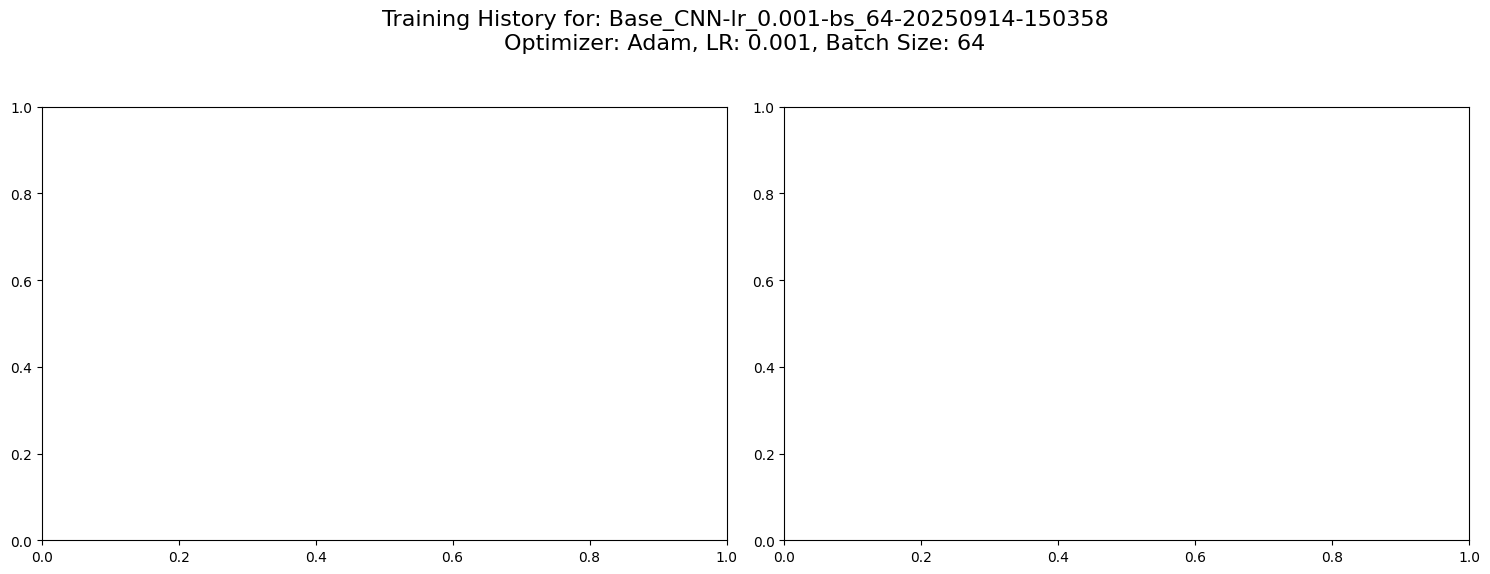

----------------------------------------------------------------------------------------------------

Processing folder: Base_CNN-lr_0.001-bs_64-20250914-151621


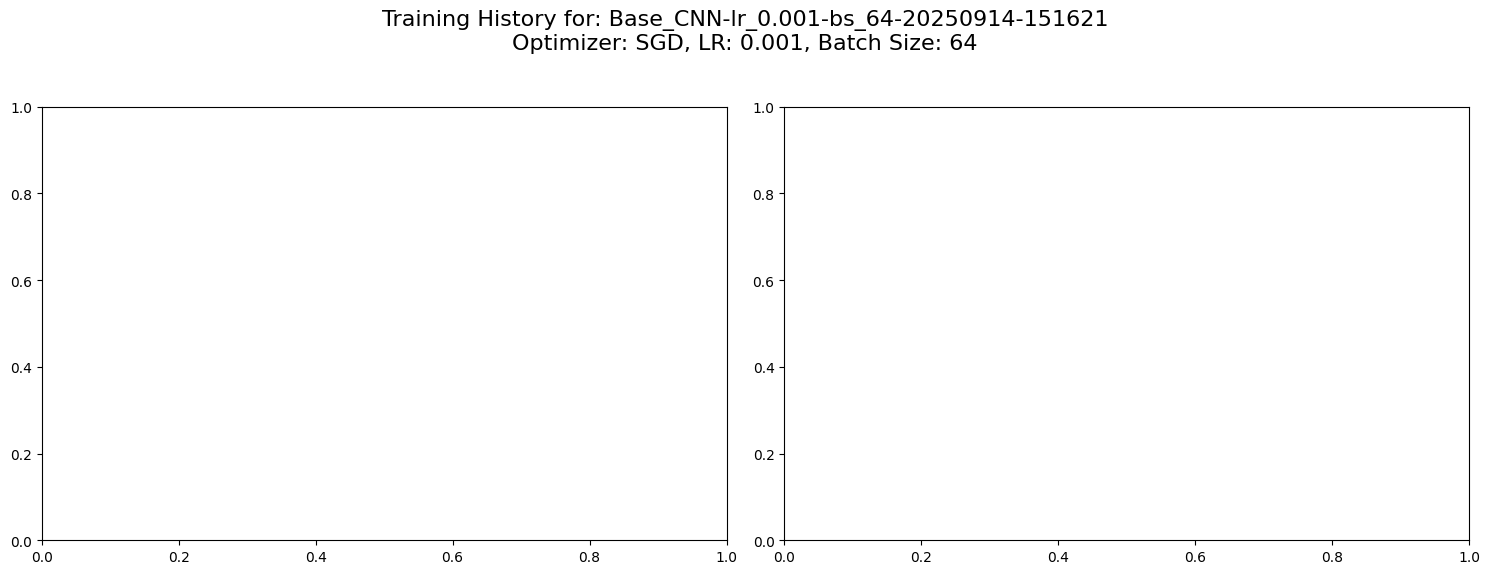

----------------------------------------------------------------------------------------------------

Processing folder: Base_CNN-lr_0.01-bs_64-20250913-203805


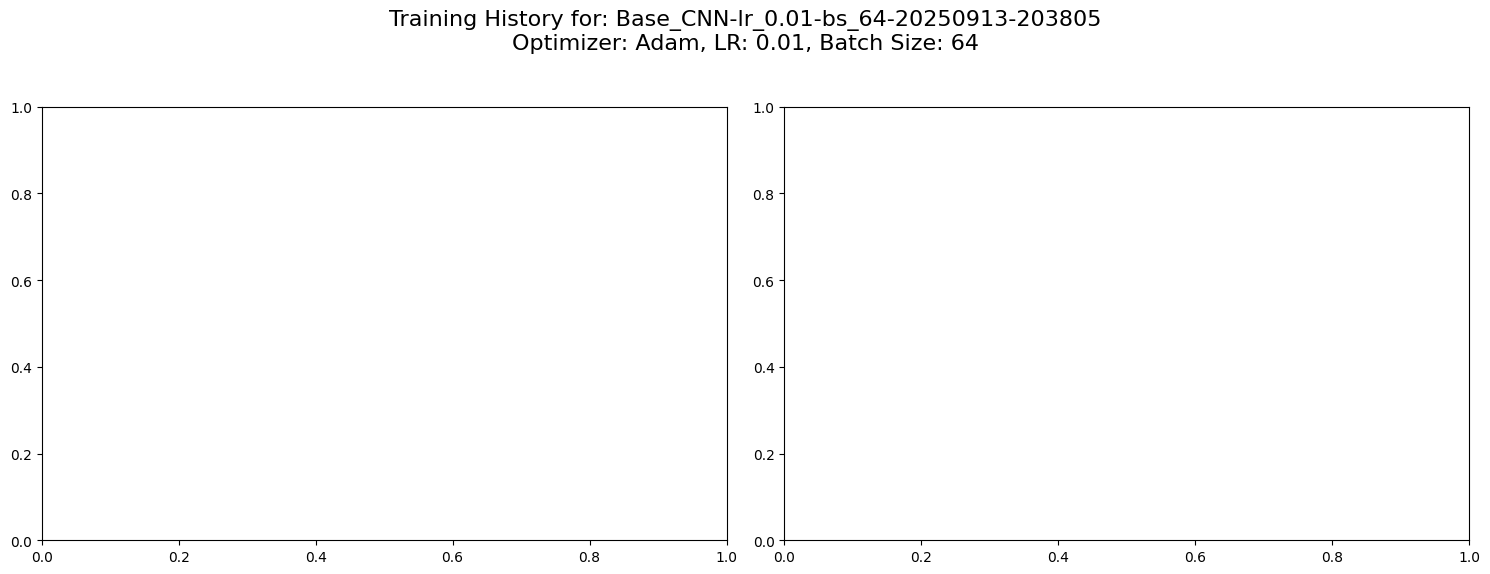

----------------------------------------------------------------------------------------------------

Processing folder: Base_CNN-lr_0.01-bs_64-20250914-151034


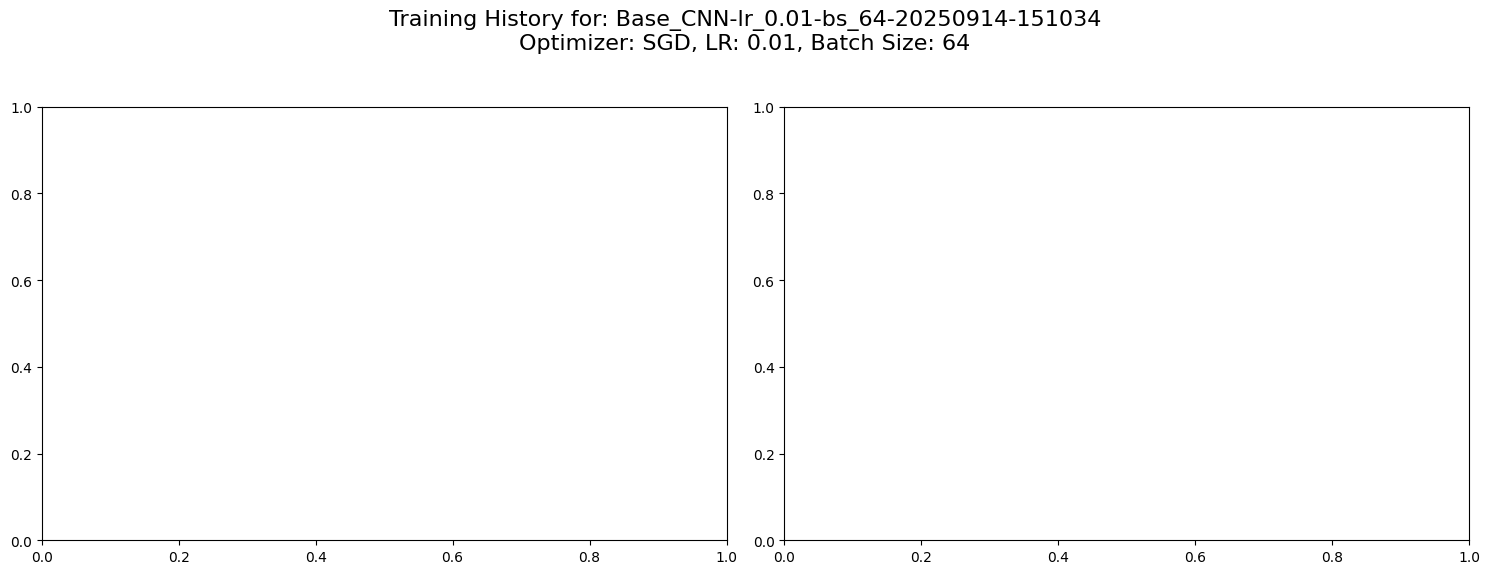

----------------------------------------------------------------------------------------------------

Processing folder: Base_MLP_Model-lr_0.001-bs_64-20250914-124529
  -> Skipping: No .parquet history files found.

Processing folder: Base_MLP_Model-lr_0.01-bs_64-20250913-201958


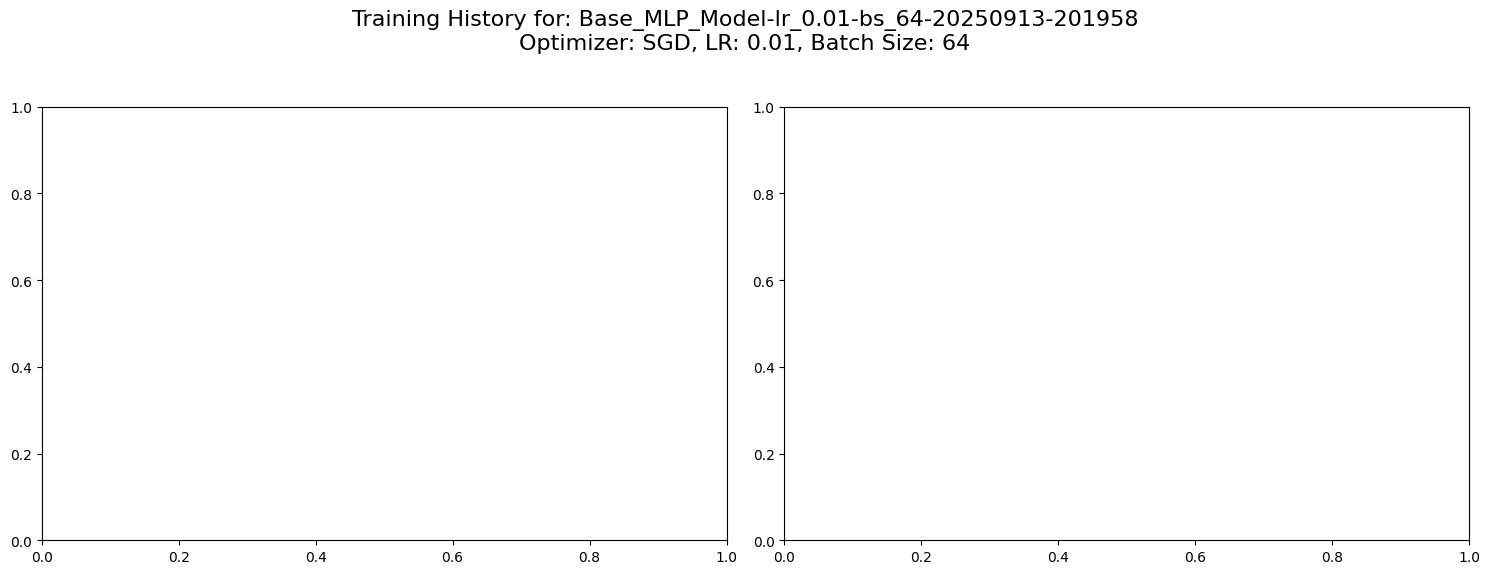

----------------------------------------------------------------------------------------------------

Processing folder: Base_MLP_Model_2-lr_0.001-bs_64-20250914-124808


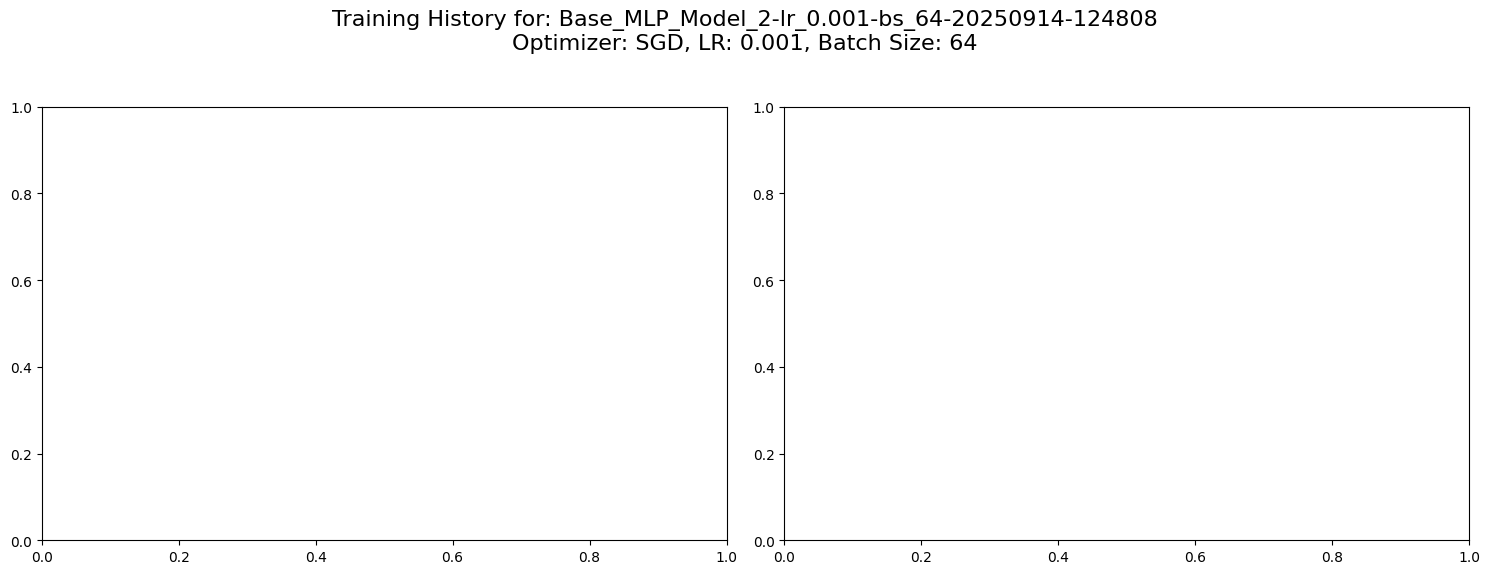

----------------------------------------------------------------------------------------------------

Processing folder: Base_MLP_Model_2-lr_0.01-bs_64-20250913-202129


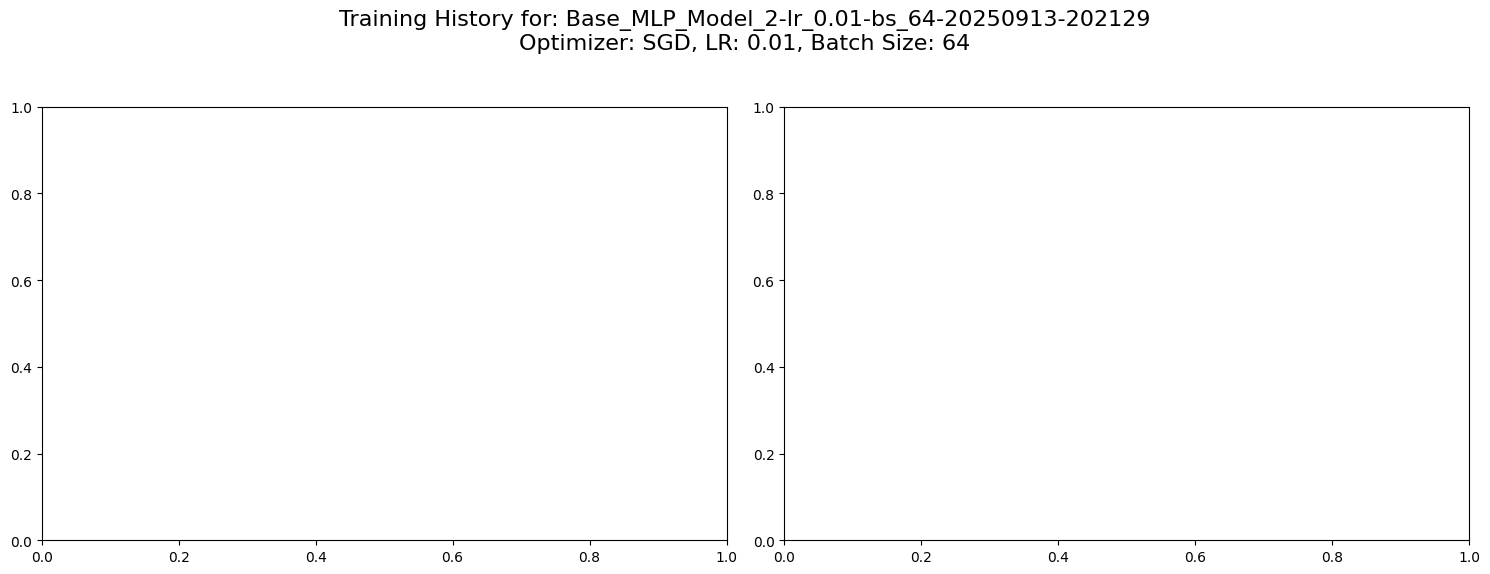

----------------------------------------------------------------------------------------------------

Processing folder: Base_MLP_Model_3-lr_0.001-bs_64-20250914-125321


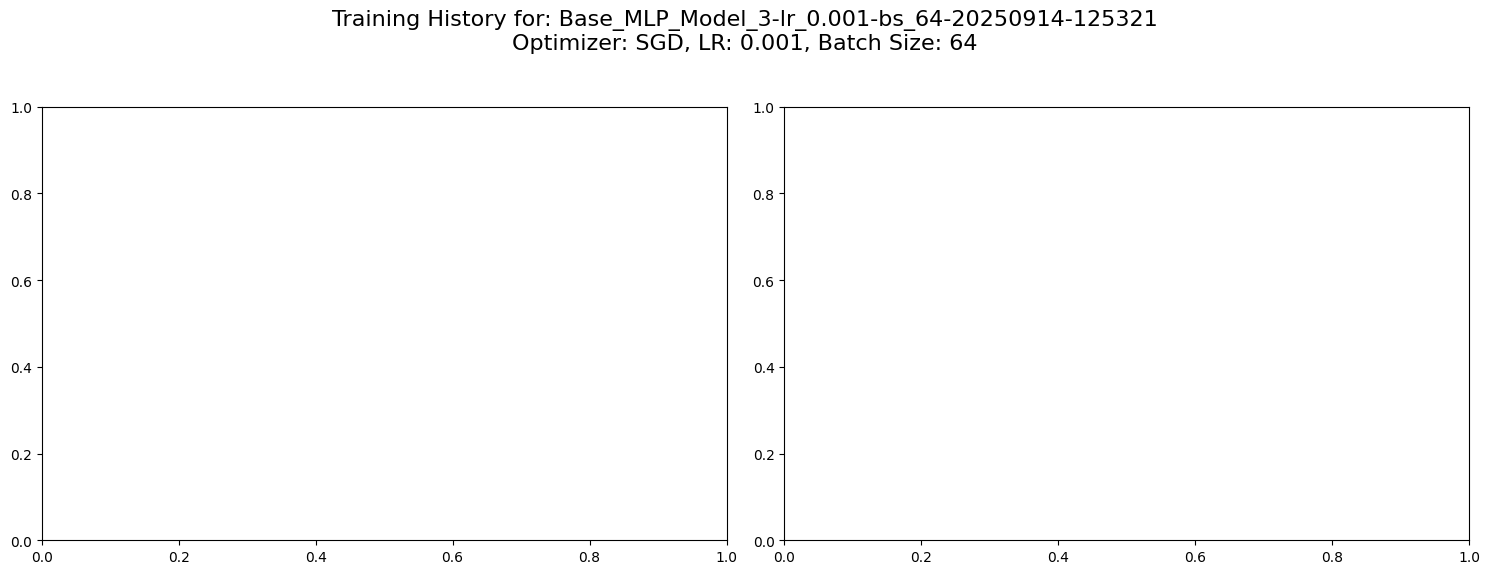

----------------------------------------------------------------------------------------------------

Processing folder: Base_MLP_Model_3-lr_0.01-bs_64-20250913-202407


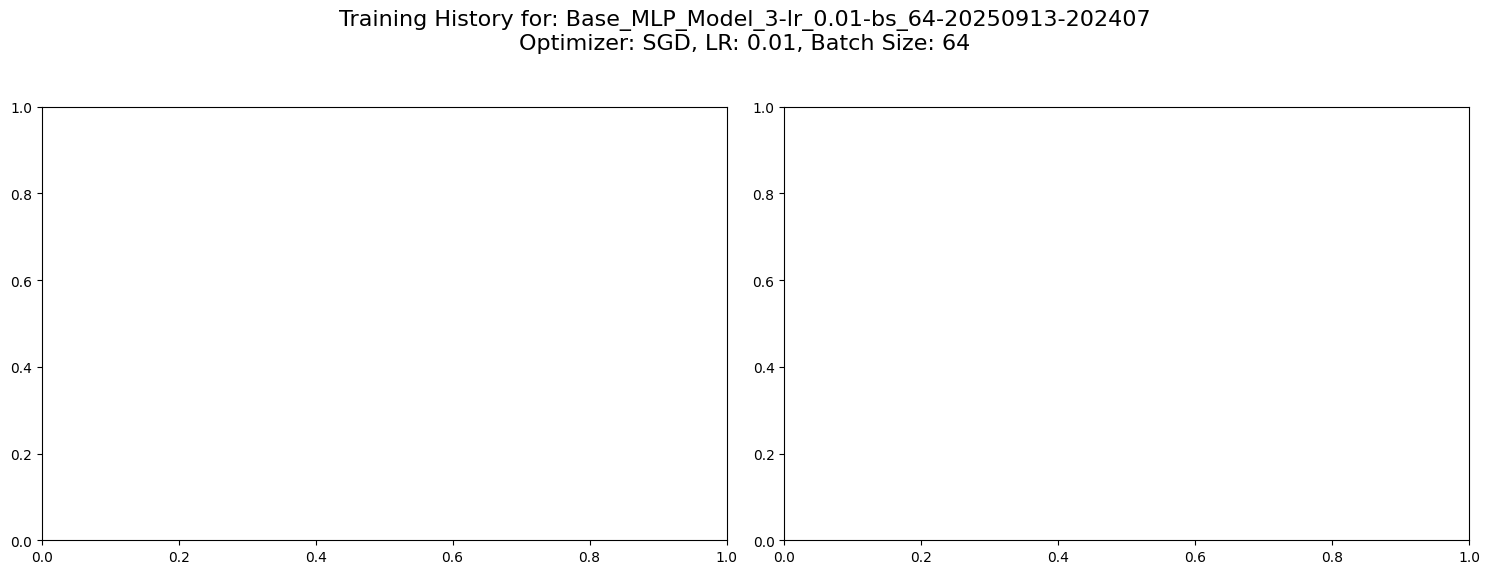

----------------------------------------------------------------------------------------------------

Processing folder: CNN_with_Dropout-lr_0.001-bs_64-20250914-153710


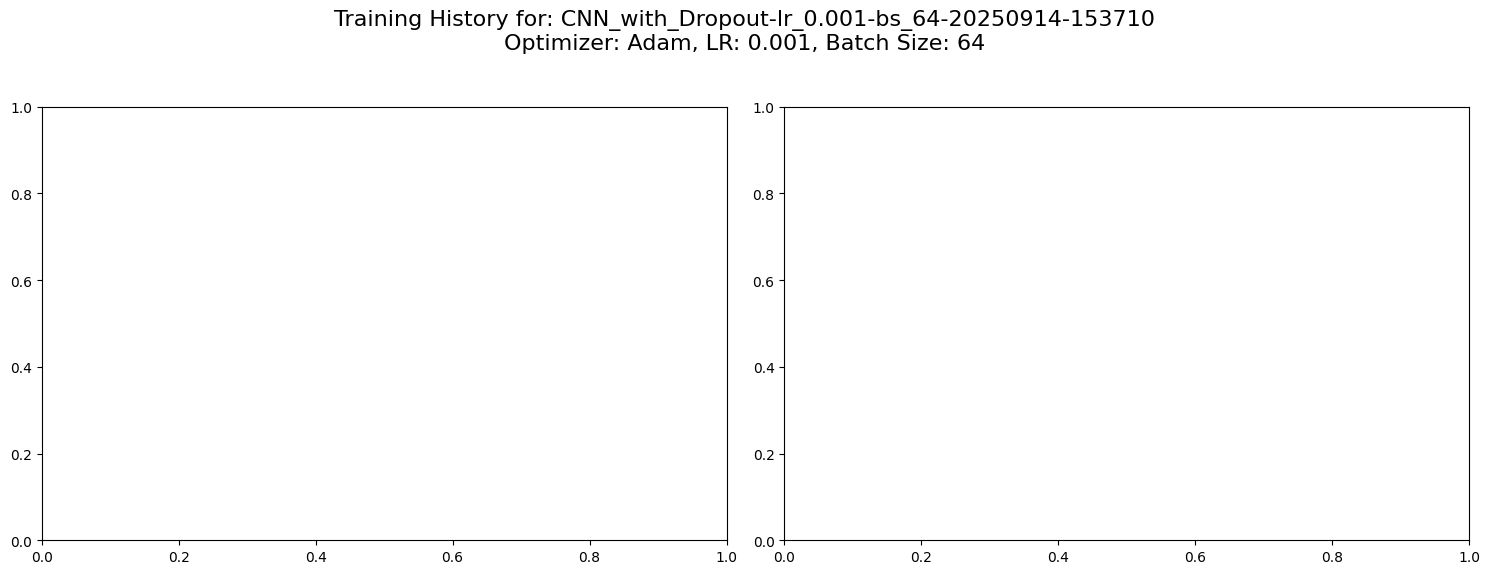

----------------------------------------------------------------------------------------------------

Processing folder: CNN_with_Dropout-lr_0.001-bs_64-20250914-155740


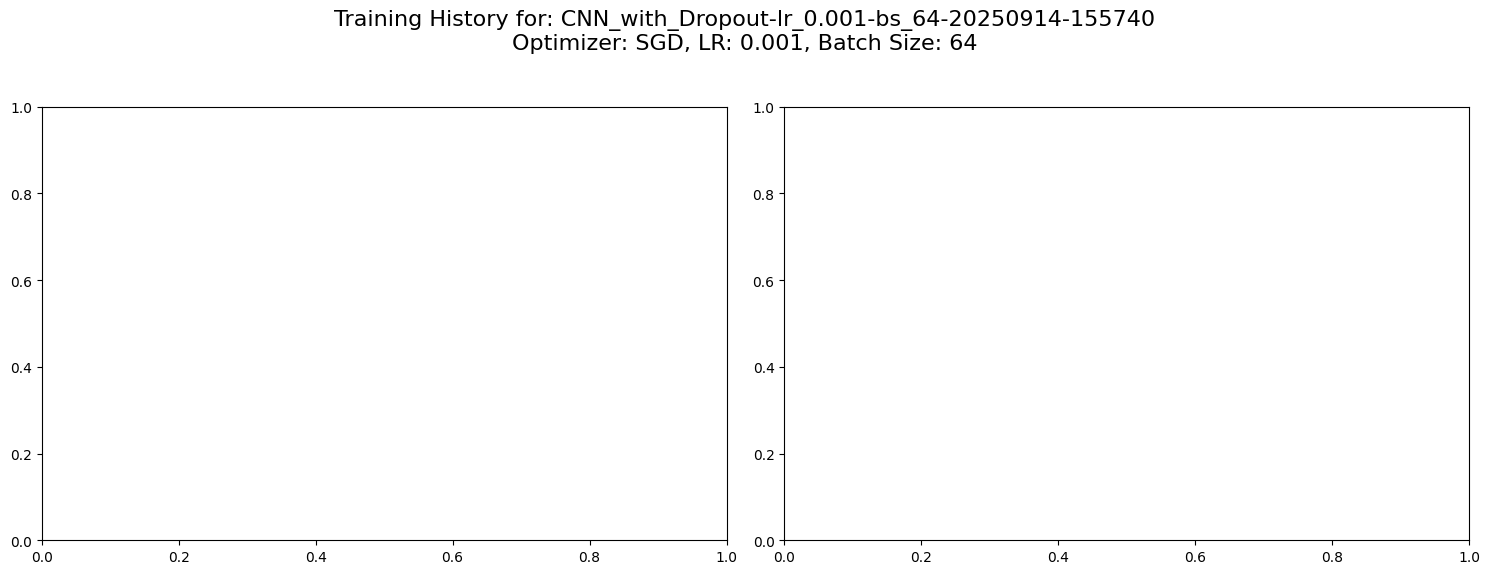

----------------------------------------------------------------------------------------------------

Processing folder: CNN_with_Dropout-lr_0.01-bs_64-20250913-204226


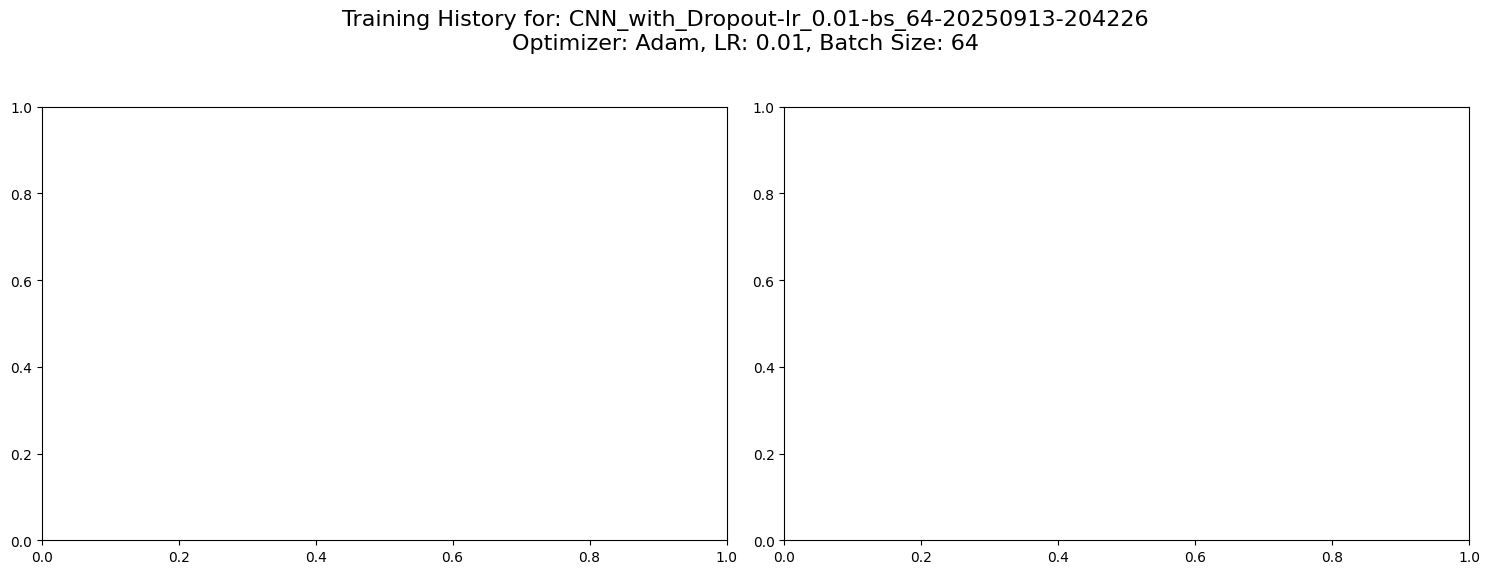

----------------------------------------------------------------------------------------------------

Processing folder: CNN_with_Dropout-lr_0.01-bs_64-20250914-154602


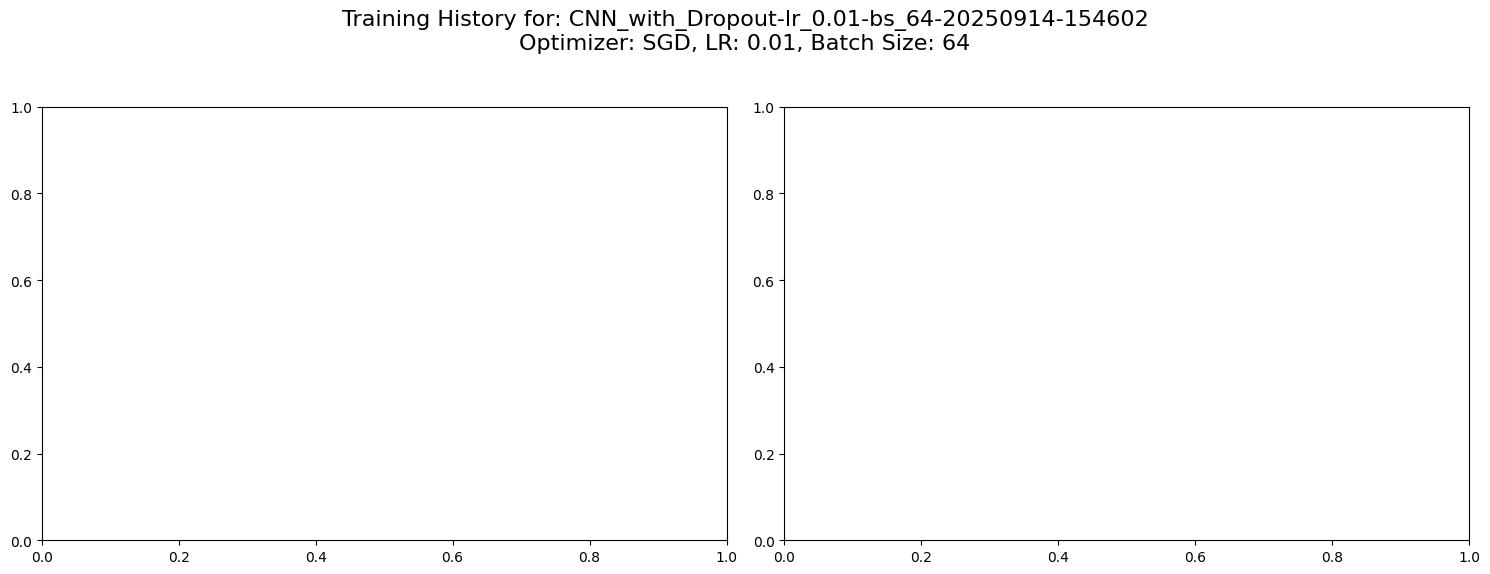

----------------------------------------------------------------------------------------------------

Processing folder: Deep_CNN_Model_Padded-lr_0.01-bs_64-20250913-205629


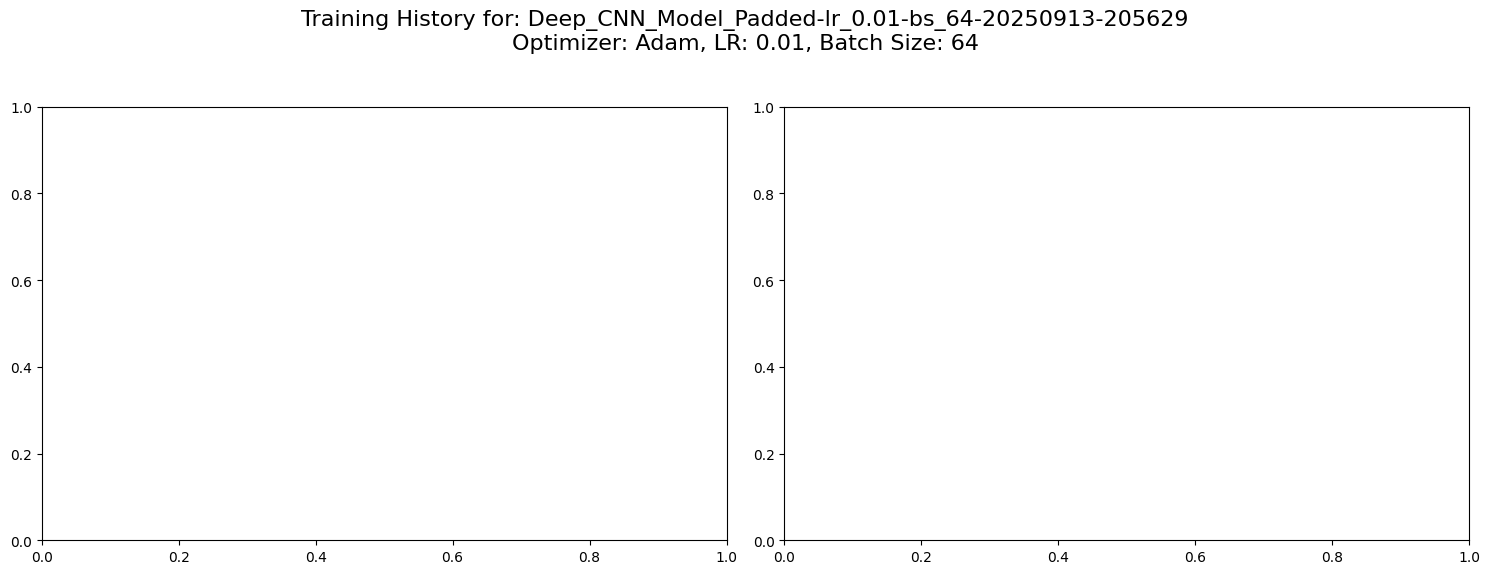

----------------------------------------------------------------------------------------------------

Processing folder: Deep_MLP_Model-lr_0.001-bs_64-20250914-131521


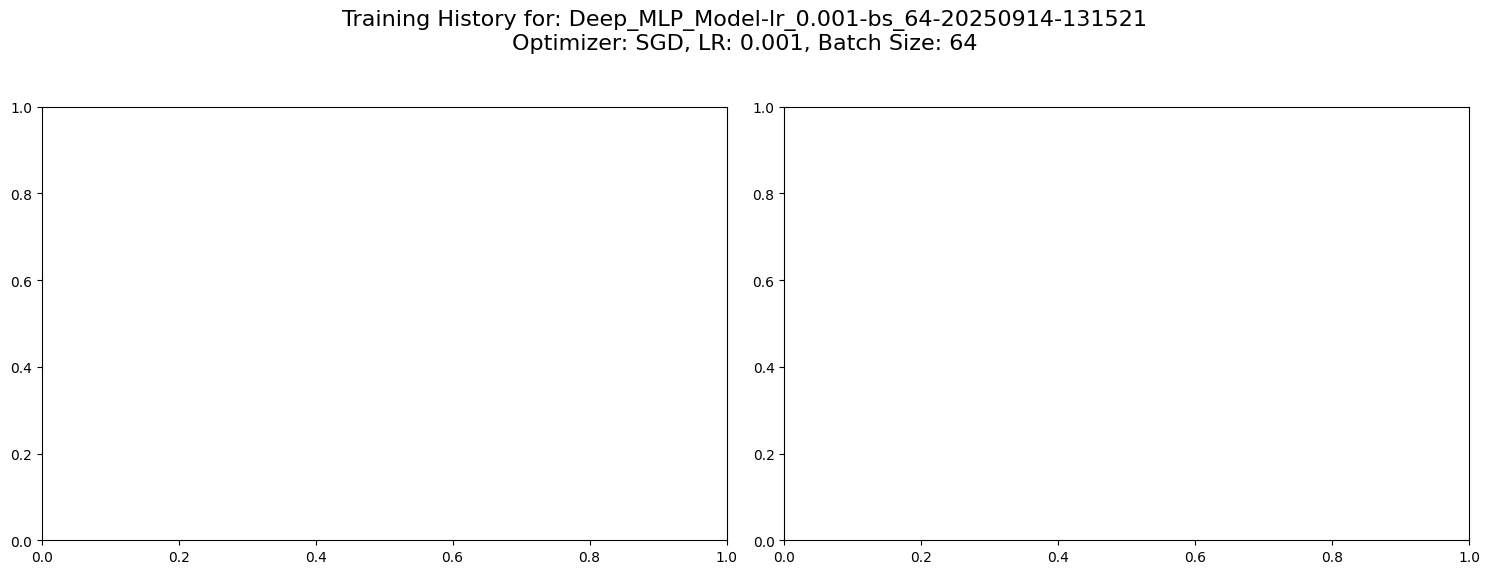

----------------------------------------------------------------------------------------------------

Processing folder: Deep_MLP_Model-lr_0.01-bs_64-20250913-203343


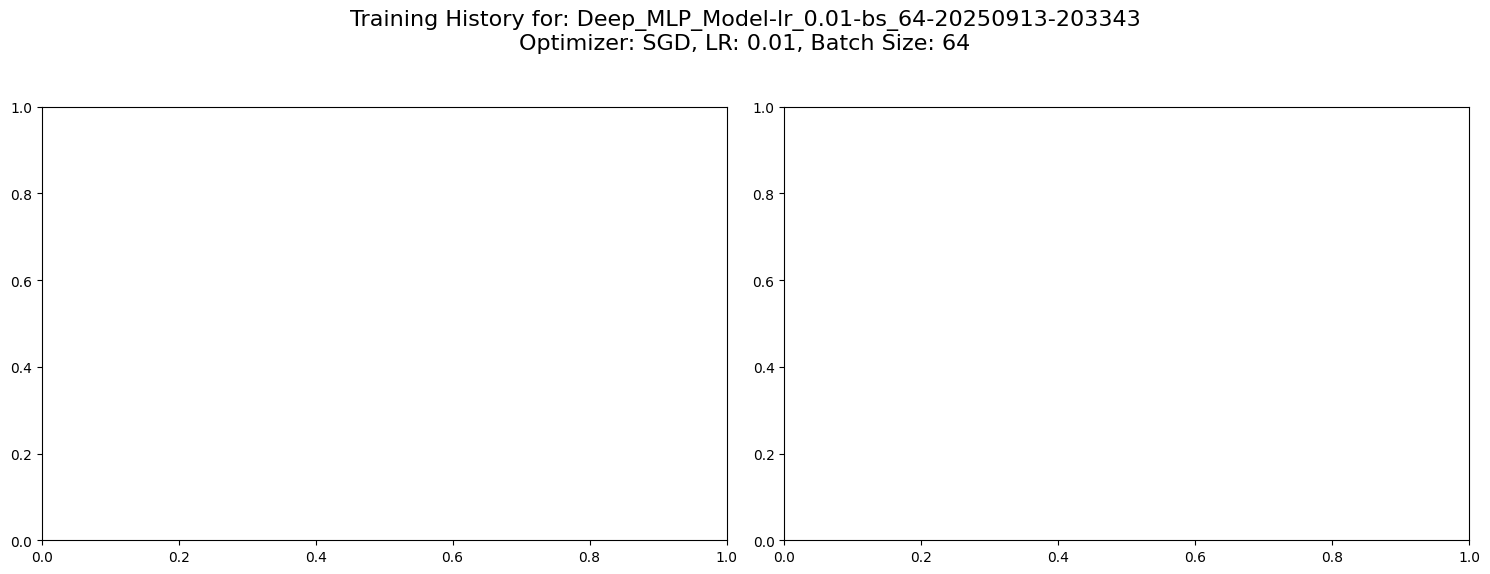

----------------------------------------------------------------------------------------------------

Processing folder: Wide_CNN_Model-lr_0.001-bs_64-20250914-162255


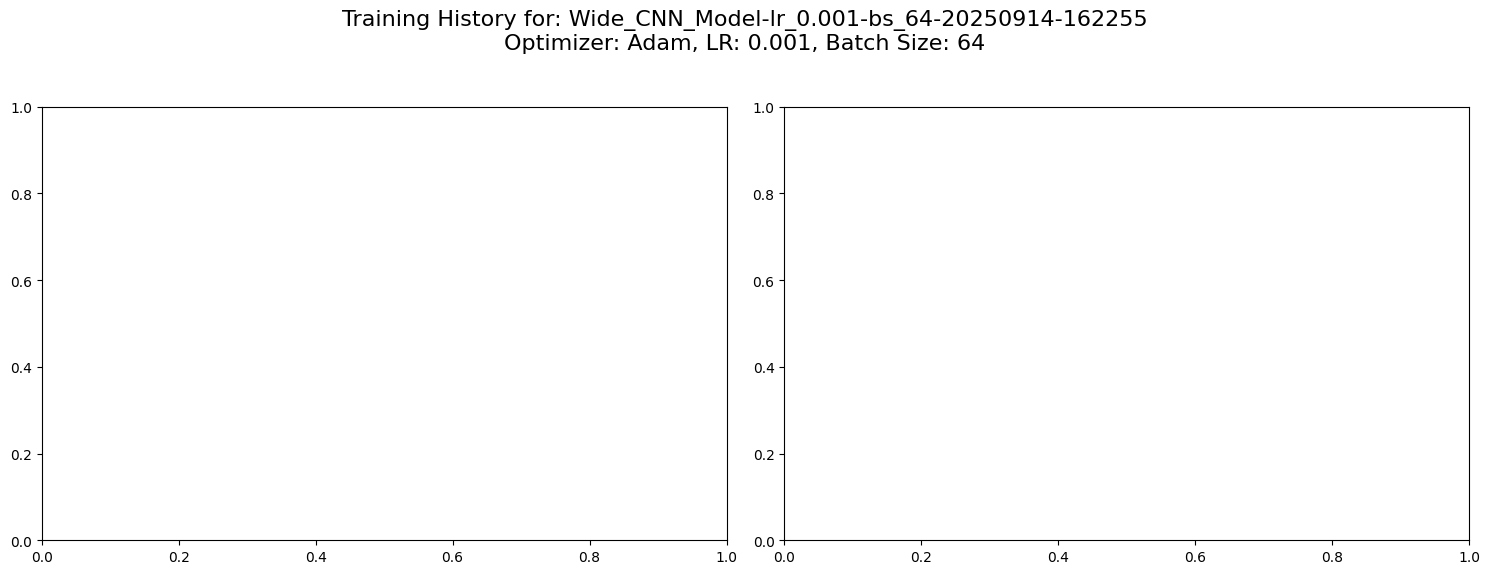

----------------------------------------------------------------------------------------------------

Processing folder: Wide_CNN_Model-lr_0.001-bs_64-20250914-165331
  -> Skipping: config.yaml not found.

Processing folder: Wide_CNN_Model-lr_0.01-bs_64-20250913-204620


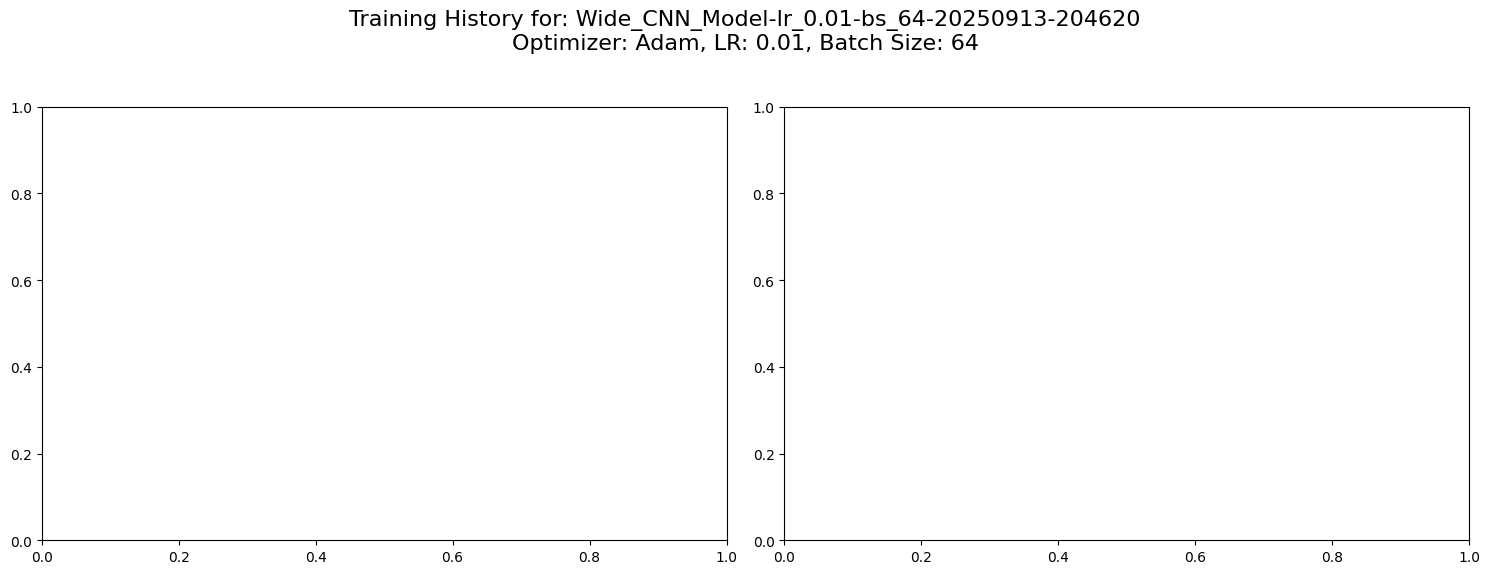

----------------------------------------------------------------------------------------------------

Processing folder: Wide_CNN_Model-lr_0.01-bs_64-20250914-163242


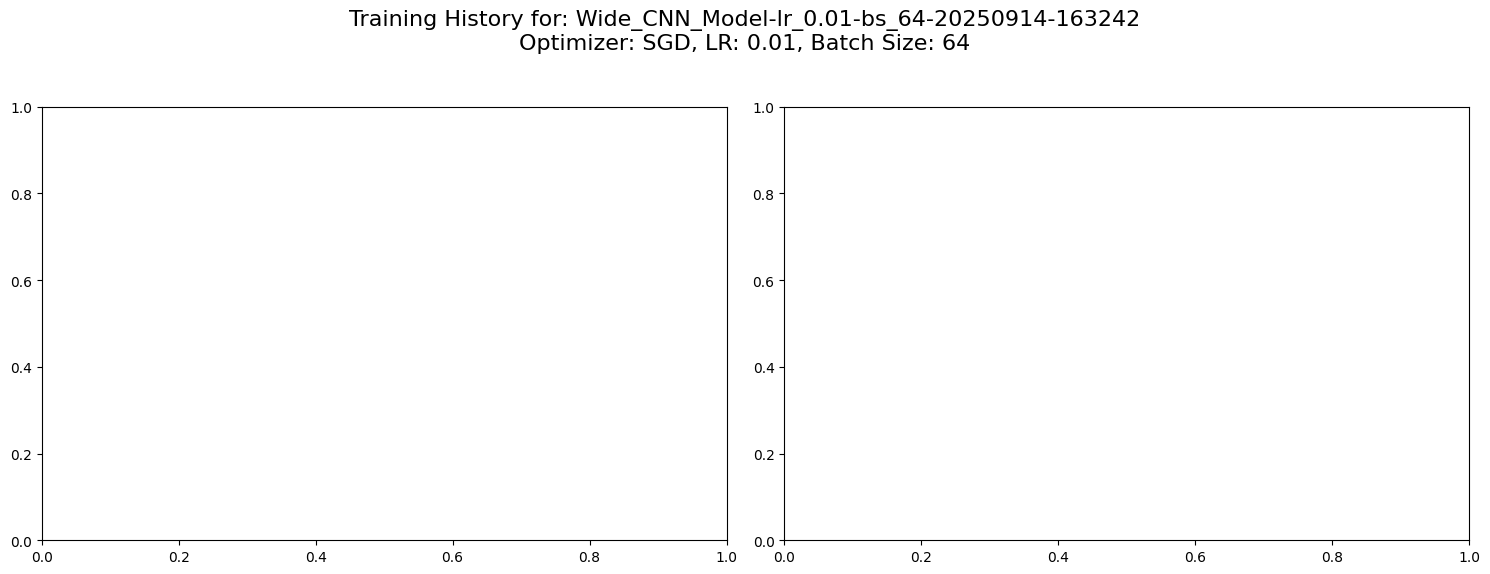

----------------------------------------------------------------------------------------------------

Processing folder: Wide_MLP_Model-lr_0.001-bs_64-20250914-130011


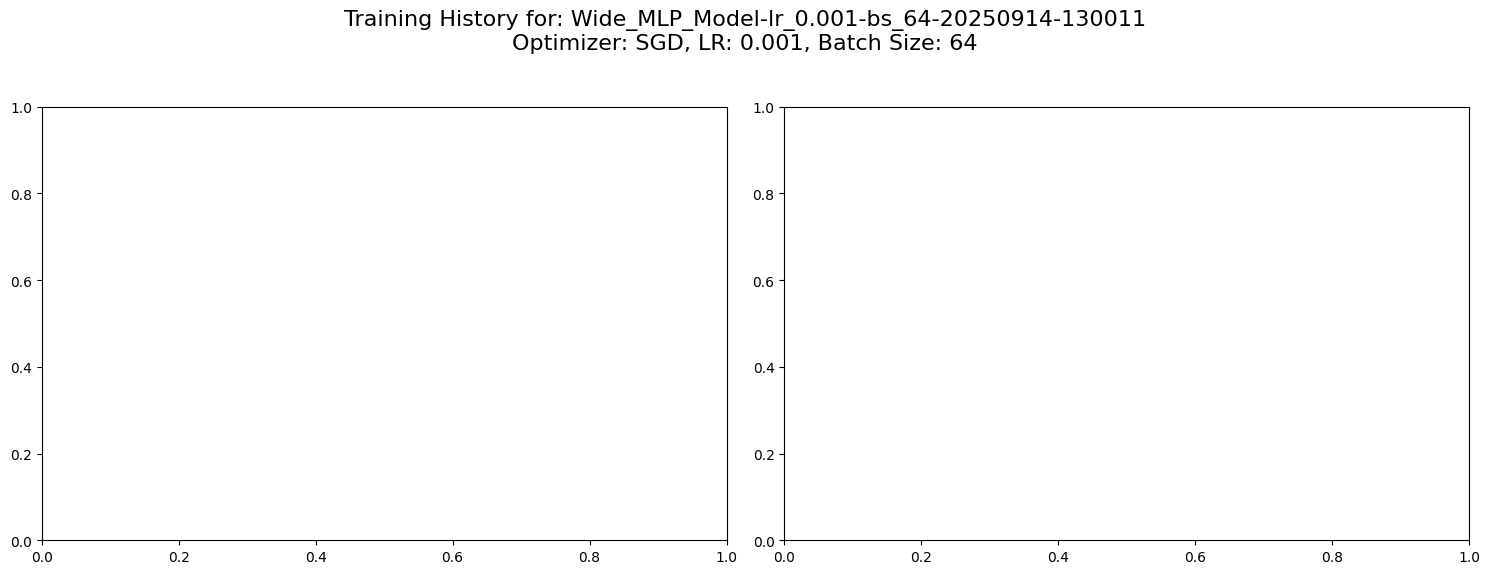

----------------------------------------------------------------------------------------------------

Processing folder: Wide_MLP_Model-lr_0.01-bs_64-20250913-202738


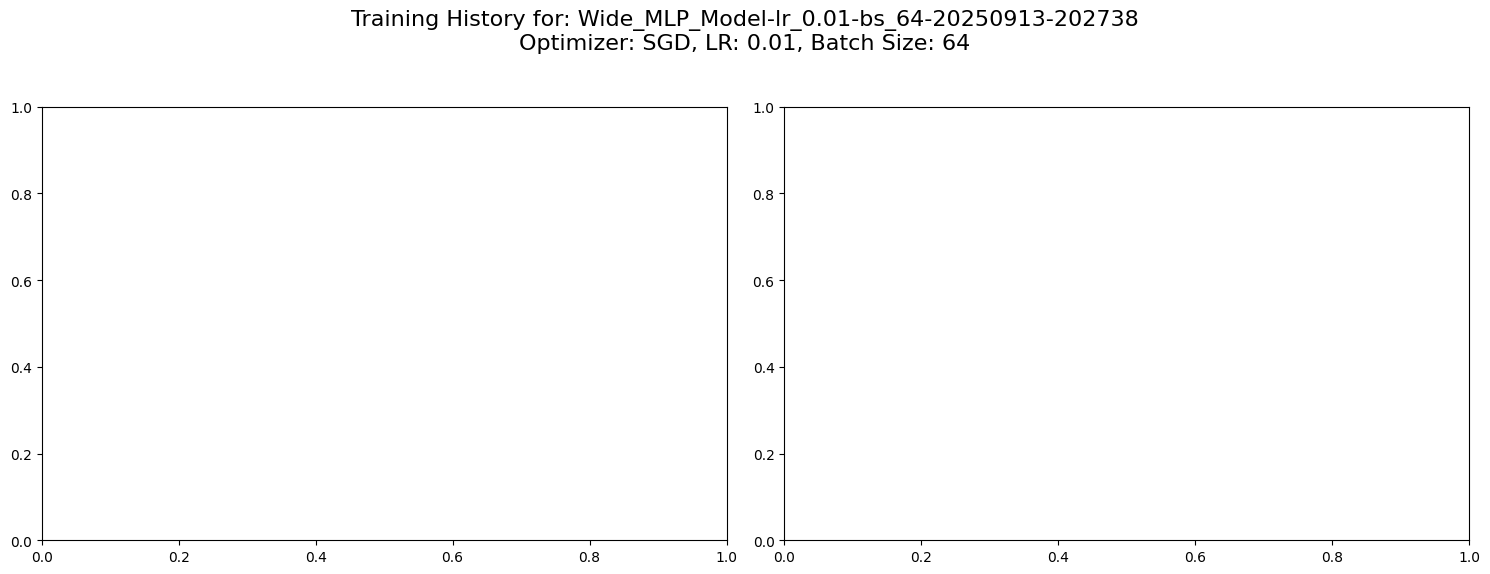

----------------------------------------------------------------------------------------------------

--- Plotting complete. Successfully plotted 21 of 23 runs. ---


In [76]:
# Define the path to your main downloads folder
wandb_downloads_path = os.path.join(os.getcwd(), 'WandB_downloads')

# Call the new function to process and plot everything inside that folder
load_and_plot_all_runs(wandb_downloads_path)

## Testing the models on the held-out test set
We test the model on the test data, which is data that the model has never seen before. Then we verify the model's real-world accuracy. It is expected that this does not deviate much from the validation sets, because the MNIST dataset contains images that are very clean and simple:
- They are small (28 x 28 pixels only).
- The digits are centered and normalised in size.
- The background is a solid colour with no distracting noise.
  
Because of this simplicity, the patterns that differentiate one digit from another (e.g., a "1" is a vertical line, an "8" is two loops) are very strong and easy for our model to learn.

First we define a function that browser to a folder with saved models, extracts the file with the highest validation accuracy in its name, loads it and tests it with the held-out X_test and Y_test. 

A function is convenient because we will use it on different models, with different hyperparameters and hence, avoid repetition. 

In [42]:
def find_load_and_analyse_best_model(
    parent_folder: str, # Changed name for clarity
    x_test_data: NDArray[np.float32], 
    y_test_data: NDArray[np.int_]
) -> Tuple[tf.keras.Model | None, float | None, float | None]:
    """
    Recursively searches through all subfolders in a parent directory to find the
    single best Keras model, then loads and analyses it.
    """
    best_model_path = None # We will now store the full path directly
    best_val_accuracy = -1.0

    pattern = re.compile(r"val_acc-([\d.]+)\.keras")

    if not os.path.isdir(parent_folder):
        print(f"Error: Parent directory not found at '{parent_folder}'")
        return None, None, None

    # os.walk() goes through a directory tree top-down.
    for dirpath, _, filenames in os.walk(parent_folder):
        for filename in filenames:
            match = pattern.search(filename)
            if match:
                val_accuracy = float(match.group(1))
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    # Construct and store the full path to this new best model
                    best_model_path = os.path.join(dirpath, filename)
    
    # The rest of the function works perfectly, we just need to use best_model_path
    if best_model_path:
        print(f"Found and loading best model across all experiments: {best_model_path}")
        
        loaded_model = tf.keras.models.load_model(best_model_path)
        
        # --- Print Compiled Hyperparameters ---
        print("\n--- Key Hyperparameters ---")
        # Gets the configuration of the model's optimiser.
        optimiser_config = loaded_model.optimizer.get_config()
        optimiser_name = optimiser_config['name']
        learning_rate = optimiser_config['learning_rate']
        
        # Gets the name of the loss function the model was compiled with.
        loss_function = loaded_model.loss
        
        print(f"{'Optimiser:':<20} {optimiser_name}")
        print(f"{'Learning Rate:':<20} {learning_rate}")
        print(f"{'Loss Function:':<20} {loss_function}")
        
        # Prints a summary table of the model's architecture.
        print("\n--- Best Model Summary (Architecture) ---")
        loaded_model.summary()

        # Evaluates the loaded model's performance on the unseen test data.
        print("\n--- Evaluating model performance on the test set ---")
        loss, accuracy = loaded_model.evaluate(x_test_data, y_test_data, verbose=1)
        
        # Prints the final evaluation results, formatted to 4 decimal places.
        print(f"\nTest Set Loss: {loss:.4f}")
        print(f"Test Set Accuracy: {accuracy:.4f}")

        # --- Generate Detailed Performance Analysis ---
        print("\n--- Detailed Analysis ---")
        
        # Use the model to predict the class for each image in the test set.
        y_pred_probabilities = loaded_model.predict(x_test_data)
        # The model outputs probabilities; we use np.argmax to find the class with the highest probability.
        y_pred = np.argmax(y_pred_probabilities, axis=1)

        # Generate and print a text report showing precision, recall, and f1-score for each digit.
        print("\n--- Classification Report ---")
        report = classification_report(y_test_data, y_pred, target_names=[str(i) for i in range(10)])
        print(report)

        # Generate and plot a confusion matrix to visualise which digits are being confused.
        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(y_test_data, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        plt.title(f'Confusion Matrix for {loaded_model.name}')
        plt.show()
        
        # Returns the loaded model object and its performance metrics for potential further use.
        return loaded_model, accuracy, loss
    else:
        # If no model files matching the pattern were found, print a message and return nothing.
        print(f"No model files found in any subfolders of '{parent_folder}'.")
        return None, None, None

### Testing the MLP model

Found and loading best model across all experiments: MLP_Models\Wide_MLP_Model-lr_0.01-bs_64-20250916-140533\best_model_epoch-29_val_acc-0.9825.keras

--- Key Hyperparameters ---
Optimiser:           SGD
Learning Rate:       0.009999999776482582
Loss Function:       sparse_categorical_crossentropy

--- Best Model Summary (Architecture) ---


Model: "Wide_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,207 (4.55 MB)

 Trainable params: 1,192,202 (4.55 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 2 (12.00 B)


--- Evaluating model performance on the test set ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9807 - loss: 0.0667

Test Set Loss: 0.0667
Test Set Accuracy: 0.9807

--- Detailed Analysis ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       

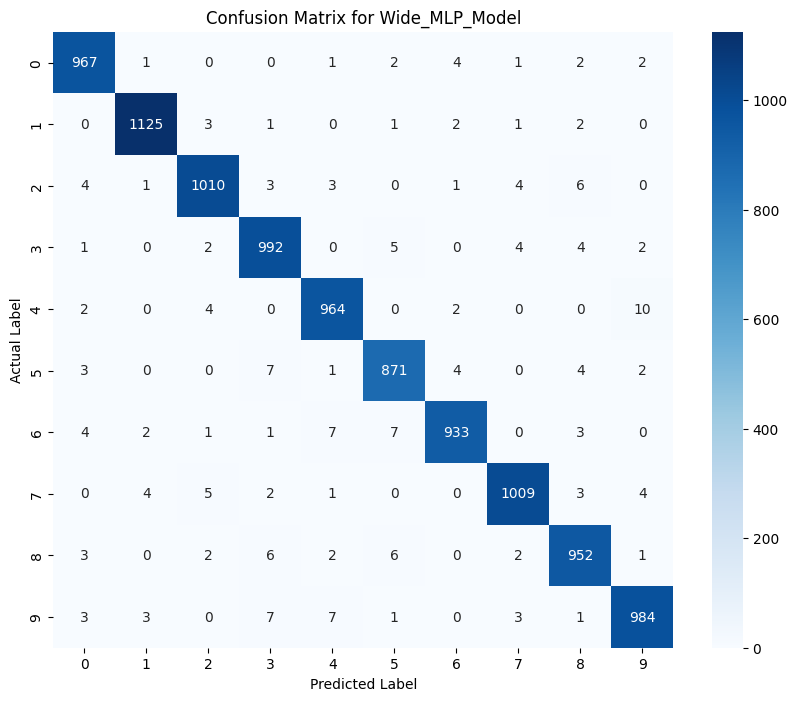

In [43]:
model_folder="MLP_Models"
# model_folder = "WandB_downloads"
# To capture the output, assign it to variables
best_model, test_acc, test_loss = find_load_and_analyse_best_model(
    parent_folder=model_folder,
    x_test_data=X_test,
    y_test_data=Y_test
)

### Testing the CNN model

Found and loading best model across all experiments: CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250916-143001\best_model_epoch-16_val_acc-0.9950.keras

--- Key Hyperparameters ---
Optimiser:           adam
Learning Rate:       0.0010000000474974513
Loss Function:       sparse_categorical_crossentropy

--- Best Model Summary (Architecture) ---


Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_7 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689,571 (10.26 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,793,046 (6.84 MB)


--- Evaluating model performance on the test set ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9931 - loss: 0.0298

Test Set Loss: 0.0298
Test Set Accuracy: 0.9931

--- Detailed Analysis ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       

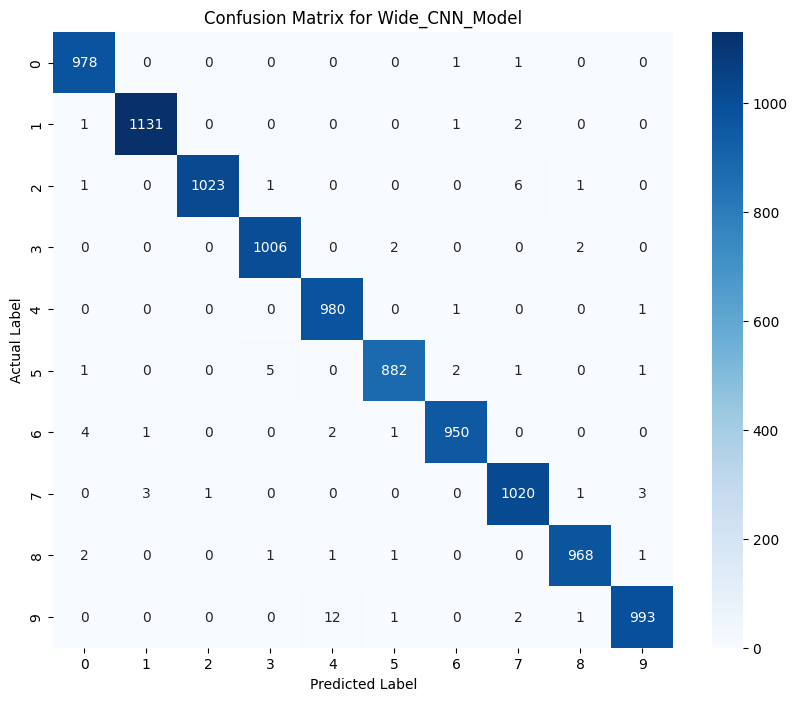

In [44]:
if run_cnn_experiments:
    model_folder='CNN_Models'
    # To capture the output, assign it to variables
    best_model, test_acc, test_loss = find_load_and_analyse_best_model(
        parent_folder=model_folder,
        x_test_data=X_test,
        y_test_data=Y_test
    )


# Future to do's (not part of this assessment)
- Implement KerasTuner (gridsearch amongst others), to automatically train and test models with a plethora of hyperparamaters, optimisers, loss functions, and select the best performing:

We first need to install it first: uv pip install keras-tuner
import keras_tuner

def build_model(hp):
    """This is our hypermodel, which defines the search space."""
    
    model = Sequential(name="Tuned_MLP")
    model.add(Input(shape=(28, 28)))
    model.add(Normalization())
    model.add(Flatten())
    
    # --- Define Hyperparameters to Tune ---
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Add the output layer
    model.add(Dense(10, activation='softmax'))

    # --- Compile the model inside the function ---
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

--- Set up the Tuner ---
### We'll use RandomSearch, which randomly tries combinations.
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # The total number of model variations to test
    executions_per_trial=2, # The number of times to train each model variation
    directory='tuning_results',
    project_name='MNIST_Tuning'
)

### --- Start the Search ---
### This is like model.fit(), but it runs the whole tuning process.
tuner.search(X_train, Y_train, epochs=10, validation_split=0.1)

### --- Get the Best Model ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Best Hyperparameters Found ---")
print(best_hyperparameters.values)

print("\n--- Evaluating the Best Model Found by the Tuner ---")
best_model.evaluate(X_test, Y_test)

# Testing a new approach (Future to do)
### A Base Class for models, with a common interface and allowing for inheriting layers, inheriting behaviour

In [33]:
# # models.py
# # This file serves as a centralised factory for creating our neural network models.
# # It uses a class-based, inherited structure to keep the codebase organised and extensible.

# import tensorflow as tf
# from tensorflow.keras.layers import Normalization, Flatten, Dense, Conv2D, MaxPooling2D
# from tensorflow.keras.models import Model

# class BaseNeuralNetwork(Model):
#     """
#     A base class for all neural networks in this project.
#     It encapsulates the common input and preprocessing layers that all models will share.
#     """
#     def __init__(self, **kwargs):
#         # We call the parent constructor to ensure correct initialisation of the Keras Model.
#         # **kwargs allows us to pass additional arguments like 'name' when creating subclasses.
#         super().__init__(**kwargs)
#         # These layers are common to all models and are defined here once for efficiency.
#         self.normalization_layer = Normalization(name="normalization_layer")
#         self.flatten_layer = Flatten(name="flatten_layer")

#     def call(self, inputs):
#         """
#         Defines the forward pass for the common preprocessing layers.
#         """
#         # The input data is passed through the normalisation and flattening layers.
#         x = self.normalization_layer(inputs)
#         x = self.flatten_layer(x)
#         return x

# class MLPModel(BaseNeuralNetwork):
#     """
#     A standard Multi-Layer Perceptron (MLP) model.
#     It inherits the base preprocessing from BaseNeuralNetwork and adds dense layers.
#     """
#     def __init__(self, num_units_1: int = 128, num_units_2: int = 256, num_units_3: int = 64, num_classes: int = 10, **kwargs):
#         # We call the parent constructor and provide a specific name for this model.
#         super().__init__(name='mlp_model', **kwargs)
#         # Define the unique dense layers for this specific model architecture.
#         self.dense_1 = Dense(units=num_units_1, activation='relu', name="dense_1")
#         self.dense_2 = Dense(units=num_units_2, activation='relu', name="dense_2")
#         self.dense_3 = Dense(units=num_units_3, activation='relu', name="dense_3")
#         self.output_layer = Dense(units=num_classes, activation='softmax', name="output_layer")

#     def call(self, inputs):
#         # First, we process the input using the base class's call method.
#         x = super().call(inputs)
#         # Then, we pass the output through the MLP-specific layers.
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         x = self.dense_3(x)
#         return self.output_layer(x)

# class MLP_Wide_Model(BaseNeuralNetwork):
#     """
#     A wider, shallower MLP model. This is a variation for experimentation.
#     """
#     def __init__(self, num_units_1: int = 256, num_units_2: int = 128, num_classes: int = 10, **kwargs):
#         super().__init__(name='mlp_wide_model', **kwargs)
#         # This model has a different configuration of dense layers.
#         self.dense_1 = Dense(units=num_units_1, activation='relu', name="dense_1")
#         self.dense_2 = Dense(units=num_units_2, activation='relu', name="dense_2")
#         self.output_layer = Dense(units=num_classes, activation='softmax', name="output_layer")

#     def call(self, inputs):
#         x = super().call(inputs)
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         return self.output_layer(x)

# class SimpleCNN(BaseNeuralNetwork):
#     """
#     A simple Convolutional Neural Network (CNN) model for image classification.
#     """
#     def __init__(self, num_classes: int = 10, **kwargs):
#         super().__init__(name='simple_cnn', **kwargs)
#         # The convolutional and pooling layers are unique to CNNs.
#         self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv1")
#         self.pool1 = MaxPooling2D(pool_size=(2, 2), name="pool1")
#         self.conv2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2")
#         self.pool2 = MaxPooling2D(pool_size=(2, 2), name="pool2")
#         self.output_layer = Dense(units=num_classes, activation='softmax', name="output_layer")

#     def call(self, inputs):
#         # We start by using the base class's normalisation.
#         x = self.normalization_layer(inputs)
        
#         # Then, we pass the output through the CNN-specific layers.
#         x = self.conv1(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)

#         # The flatten layer from the base class is still applied before the output layer.
#         x = self.flatten_layer(x)
        
#         return self.output_layer(x)

# class DeepCNN(BaseNeuralNetwork):
#     """
#     A deeper CNN model with more layers for greater representational capacity.
#     """
#     def __init__(self, num_classes: int = 10, **kwargs):
#         super().__init__(name='deep_cnn', **kwargs)
#         # This model has a more complex arrangement of convolutional layers.
#         self.conv1 = Conv2D(32, (3, 3), activation='relu')
#         self.conv2 = Conv2D(32, (3, 3), activation='relu')
#         self.pool1 = MaxPooling2D(pool_size=(2, 2))
#         self.conv3 = Conv2D(64, (3, 3), activation='relu')
#         self.conv4 = Conv2D(64, (3, 3), activation='relu')
#         self.pool2 = MaxPooling2D(pool_size=(2, 2))
#         self.dense1 = Dense(128, activation='relu')
#         self.output_layer = Dense(units=num_classes, activation='softmax')

#     def call(self, inputs):
#         x = self.normalization_layer(inputs)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.pool1(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.pool2(x)
#         x = self.flatten_layer(x)
#         x = self.dense1(x)
#         return self.output_layer(x)

# def create_model_from_class(model_class: type, input_shape, **kwargs):
#     """
#     A helper function to instantiate a model class with a defined input shape.
#     It automatically builds the model for you.
#     """
#     model_instance = model_class(**kwargs)
#     # The build method ensures that the model's layers are initialised with the correct input shape.
#     model_instance.build(input_shape=(None,) + input_shape)
#     return model_instance


# Just a thought for now. It may or may not simplify creating models, but only by a margin. It does however increase complexity of the code, so that's the trade-off. 